# Feature Selection

In [1]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import os
import zipfile
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [2]:
files = [ "HCDR/"+f for f in os.listdir("HCDR")]
files
datasets = {}
for f in files:
    name = f.split("/")[1].split('.')[0]
    print(f"loading {name}")
    datasets[name] = pd.read_csv(f)
    
print()    
print(datasets.keys())

loading application_test
loading application_train
loading bureau
loading bureau_balance
loading credit_card_balance
loading installments_payments
loading POS_CASH_balance
loading previous_application

dict_keys(['application_test', 'application_train', 'bureau', 'bureau_balance', 'credit_card_balance', 'installments_payments', 'POS_CASH_balance', 'previous_application'])


## Print Info and Description Summaries of Files

In [3]:
def print_info(df):
    print ("INFO:")
    print(datasets[df].info(verbose=True, null_counts=True))
    print()
    print("DATA DESCRIPTION: ")
    print(datasets[df].describe())
    

In [4]:
for file_name in datasets.keys(): 
    print(f"File: {file_name}".upper())
    print("--------------------------")
    print_info(file_name)
    print()
    print("*************************************************************************************")
    print()

FILE: APPLICATION_TEST
--------------------------
INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 121 columns):
 #    Column                        Non-Null Count  Dtype  
---   ------                        --------------  -----  
 0    SK_ID_CURR                    48744 non-null  int64  
 1    NAME_CONTRACT_TYPE            48744 non-null  object 
 2    CODE_GENDER                   48744 non-null  object 
 3    FLAG_OWN_CAR                  48744 non-null  object 
 4    FLAG_OWN_REALTY               48744 non-null  object 
 5    CNT_CHILDREN                  48744 non-null  int64  
 6    AMT_INCOME_TOTAL              48744 non-null  float64
 7    AMT_CREDIT                    48744 non-null  float64
 8    AMT_ANNUITY                   48720 non-null  float64
 9    AMT_GOODS_PRICE               48744 non-null  float64
 10   NAME_TYPE_SUITE               47833 non-null  object 
 11   NAME_INCOME_TYPE              48744 non-null  ob

## Feature Selection for application_train: 

### Correlations for Numerical Data

In [3]:
#application_train
train = datasets['application_train']
corrs = pd.DataFrame(train.corr()['TARGET']).rename(columns={"TARGET":"cor"})
corrs["abs_corr"] = corrs.abs()
corrs = corrs.sort_values("cor")
print(corrs)

                                  cor  abs_corr
EXT_SOURCE_3                -0.178919  0.178919
EXT_SOURCE_2                -0.160472  0.160472
EXT_SOURCE_1                -0.155317  0.155317
DAYS_EMPLOYED               -0.044932  0.044932
FLOORSMAX_AVG               -0.044003  0.044003
...                               ...       ...
DAYS_LAST_PHONE_CHANGE       0.055218  0.055218
REGION_RATING_CLIENT         0.058899  0.058899
REGION_RATING_CLIENT_W_CITY  0.060893  0.060893
DAYS_BIRTH                   0.078239  0.078239
TARGET                       1.000000  1.000000

[106 rows x 2 columns]


In [4]:
# Top Correlated Features
print("10 Most positive correlations to Target:")
print("-------------------------------------------------------")
print(corrs["cor"].tail(10))
print()

print("\n10 Most negative correlations to Target:")
print("-------------------------------------------------------")
print(corrs["cor"].head(10))
print()

print("\n10 Most correlated to Target (by absolute value):")
print("-------------------------------------------------------")
top_10_corrs = corrs.sort_values("abs_corr", ascending=False).head(11)
print(top_10_corrs)

10 Most positive correlations to Target:
-------------------------------------------------------
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: cor, dtype: float64


10 Most negative correlations to Target:
-------------------------------------------------------
EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227
ELEVATORS_AVG              

Other logical numerical variables to consider: 
- 'AMT_INCOME_TOTAL'
- 'AMT_CREDIT'  

Total income, Amount of credit are all impactful factors on a person's likelihood of paying back a loan. 

In [5]:
#Update Numerical Features List to account for Correlation and Logic
selected_num_features = list(top_10_corrs.index)
other_num_features = ['AMT_INCOME_TOTAL','AMT_CREDIT']

for feature in other_num_features: 
    selected_num_features.append(feature)

In [6]:
print("Updated Numerical Features: \n")
for col in selected_num_features:
    print(col)
    
print(f"\n# of Updated Numerical Features Based on High Correlation: {len(selected_num_features)}")

Updated Numerical Features: 

TARGET
EXT_SOURCE_3
EXT_SOURCE_2
EXT_SOURCE_1
DAYS_BIRTH
REGION_RATING_CLIENT_W_CITY
REGION_RATING_CLIENT
DAYS_LAST_PHONE_CHANGE
DAYS_ID_PUBLISH
REG_CITY_NOT_WORK_CITY
FLAG_EMP_PHONE
AMT_INCOME_TOTAL
AMT_CREDIT

# of Updated Numerical Features Based on High Correlation: 13


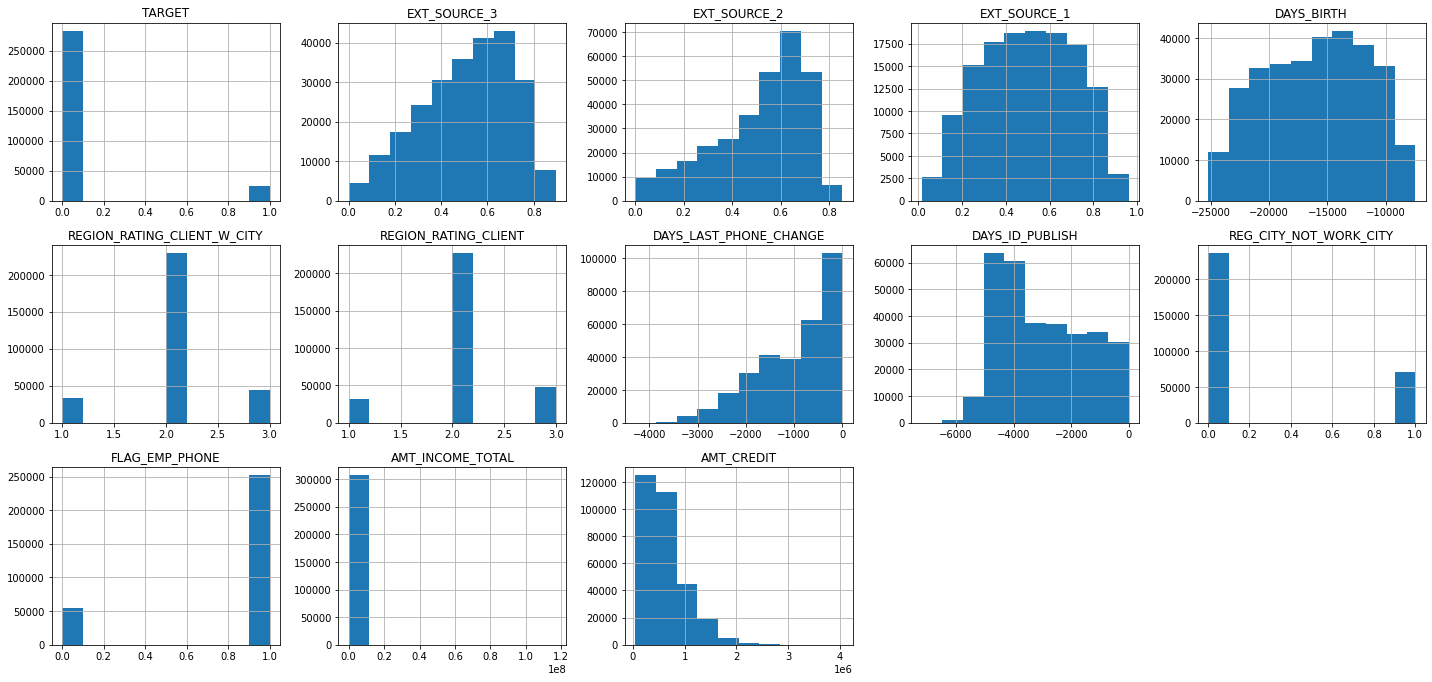

In [7]:
#Distribution Plots of highest correlated input variables. 
# selected_num_features.remove('TARGET')

cnt_cols = len(selected_num_features)

plt.figure(figsize = (20,40))
for i, var in enumerate (selected_num_features):
    plt.subplot(cnt_cols,5, i+1)
    datasets["application_train"][var].hist()
    
    plt.title (var)
    plt.tight_layout()

plt.show()

Text(0.5, 1.0, 'Correlation Heatmap of Top Correlated Features to Target in application_train')

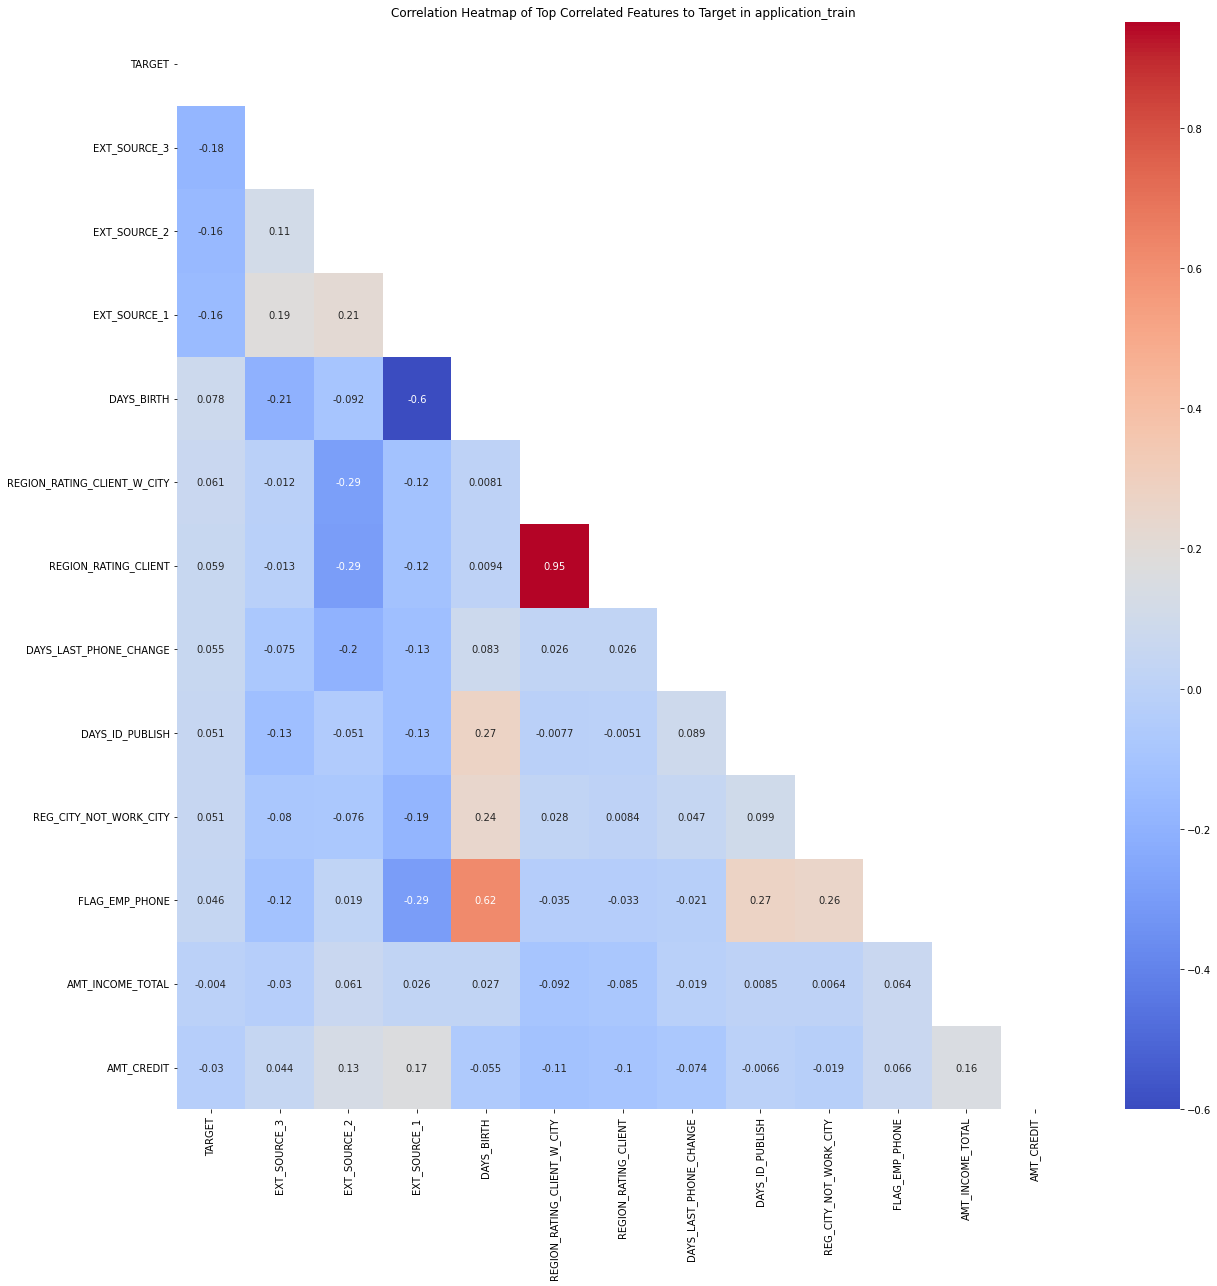

In [8]:
#Correlation Heatmap of top most correlated variables with Target
# selected_num_features.insert(0, 'TARGET')
selected_num_features_df = train[selected_num_features]

#Correlation Matrix
selected_num_features_cm = selected_num_features_df.corr()

#Plot Correlation Matrix as a heatmap
mask = np.triu(selected_num_features_cm)

plt.figure(figsize=(20,20))
sns.heatmap(selected_num_features_cm, cmap=plt.cm.coolwarm, annot=True, mask=mask )
plt.title("Correlation Heatmap of Top Correlated Features to Target in application_train")

In [9]:
# Reference: "https://www.geeksforgeeks.org/sort-correlation-matrix-in-python/".

def get_top_abs_correlations(cm):
    # Retain upper triangular values of correlation matrix and 
    # make Lower triangular values Null
    upper_corr_mat = cm.where(np.triu(np.ones(cm.shape),k=1).astype(np.bool))
    
    # Convert to 1-D series and drop Null values 
    unique_corr_pairs = upper_corr_mat.unstack().dropna() 
    
    # Sort correlation pairs 
    sorted_mat = unique_corr_pairs.abs().sort_values() 
    
    return (sorted_mat[sorted_mat > 0.7])


top_abs_corrs = pd.DataFrame(get_top_abs_correlations(selected_num_features_cm))
print("Absolute Correlations > 0.7 Pearson Coefficent:")
top_abs_corrs.columns = ['Correlation Factor']
print(top_abs_corrs)



Absolute Correlations > 0.7 Pearson Coefficent:
                                                  Correlation Factor
REGION_RATING_CLIENT REGION_RATING_CLIENT_W_CITY            0.950842


In [10]:
top_abs_corrs ['Feature 1 Correlation with Target']=0
top_abs_corrs ['Feature 2 Correlation with Target']=0
i=0

for feature in top_abs_corrs.index:
    top_abs_corrs ['Feature 1 Correlation with Target'].iloc[i] = selected_num_features_cm['TARGET'].loc[feature[0]]
    top_abs_corrs ['Feature 2 Correlation with Target'].iloc[i] = selected_num_features_cm['TARGET'].loc[feature[1]]
    i+=1


In [11]:
top_abs_corrs

,,Correlation Factor,Feature 1 Correlation with Target,Feature 2 Correlation with Target
REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,0.950842,0.058899,0.060893


### Correlation Observations: 
In the updated selected numerical columns selected from the Application Training dataset, 2 of the input features were highly correlated with each other. We considered a 'high correlation' when the Pearson Correlation Factor was greater than 0.7, per industry standard. 

**Feature Selection** 
For these highly correlated input features, we selected one input feature per pair based on the highest correlation factor with the target variable and best judgement if this factor is the same. 

Input Features to drop: 
- 'TARGET' --> Output Feature
- 'REGION_RATING_CLIENT
- 'FLAG_EMP_PHONE' --> Flag is categorical





In [12]:
inputs_to_drop = ['TARGET','REGION_RATING_CLIENT','FLAG_EMP_PHONE']

for input_var in inputs_to_drop: 
    selected_num_features.remove(input_var)
    
print("Updated Numerical Features based on Correlation Accounting for Multicollinearity:".upper())    
print("-------------------------------------------------------------------------------------")
for col in selected_num_features:
    print(col)
    
print(f"\n# of Variables Listed Above: {len(selected_num_features)}") 

UPDATED NUMERICAL FEATURES BASED ON CORRELATION ACCOUNTING FOR MULTICOLLINEARITY:
-------------------------------------------------------------------------------------
EXT_SOURCE_3
EXT_SOURCE_2
EXT_SOURCE_1
DAYS_BIRTH
REGION_RATING_CLIENT_W_CITY
DAYS_LAST_PHONE_CHANGE
DAYS_ID_PUBLISH
REG_CITY_NOT_WORK_CITY
AMT_INCOME_TOTAL
AMT_CREDIT

# of Variables Listed Above: 10


### Categorical Features

In [15]:
selected_cat_features = []
for col in train: 
    if train[col].dtype == 'object':
        selected_cat_features.append(col)

#Print Categorical Features
print("Categorical Features:")
print("---------------------")
for col in selected_cat_features: 
    print(col)
    
selected_cat_features_len = len(selected_cat_features)
print(f"\n# of Categorical Features: {selected_cat_features_len}\n")

Categorical Features:
---------------------
NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
OCCUPATION_TYPE
WEEKDAY_APPR_PROCESS_START
ORGANIZATION_TYPE
FONDKAPREMONT_MODE
HOUSETYPE_MODE
WALLSMATERIAL_MODE
EMERGENCYSTATE_MODE

# of Categorical Features: 16



<Figure size 720x864 with 0 Axes>

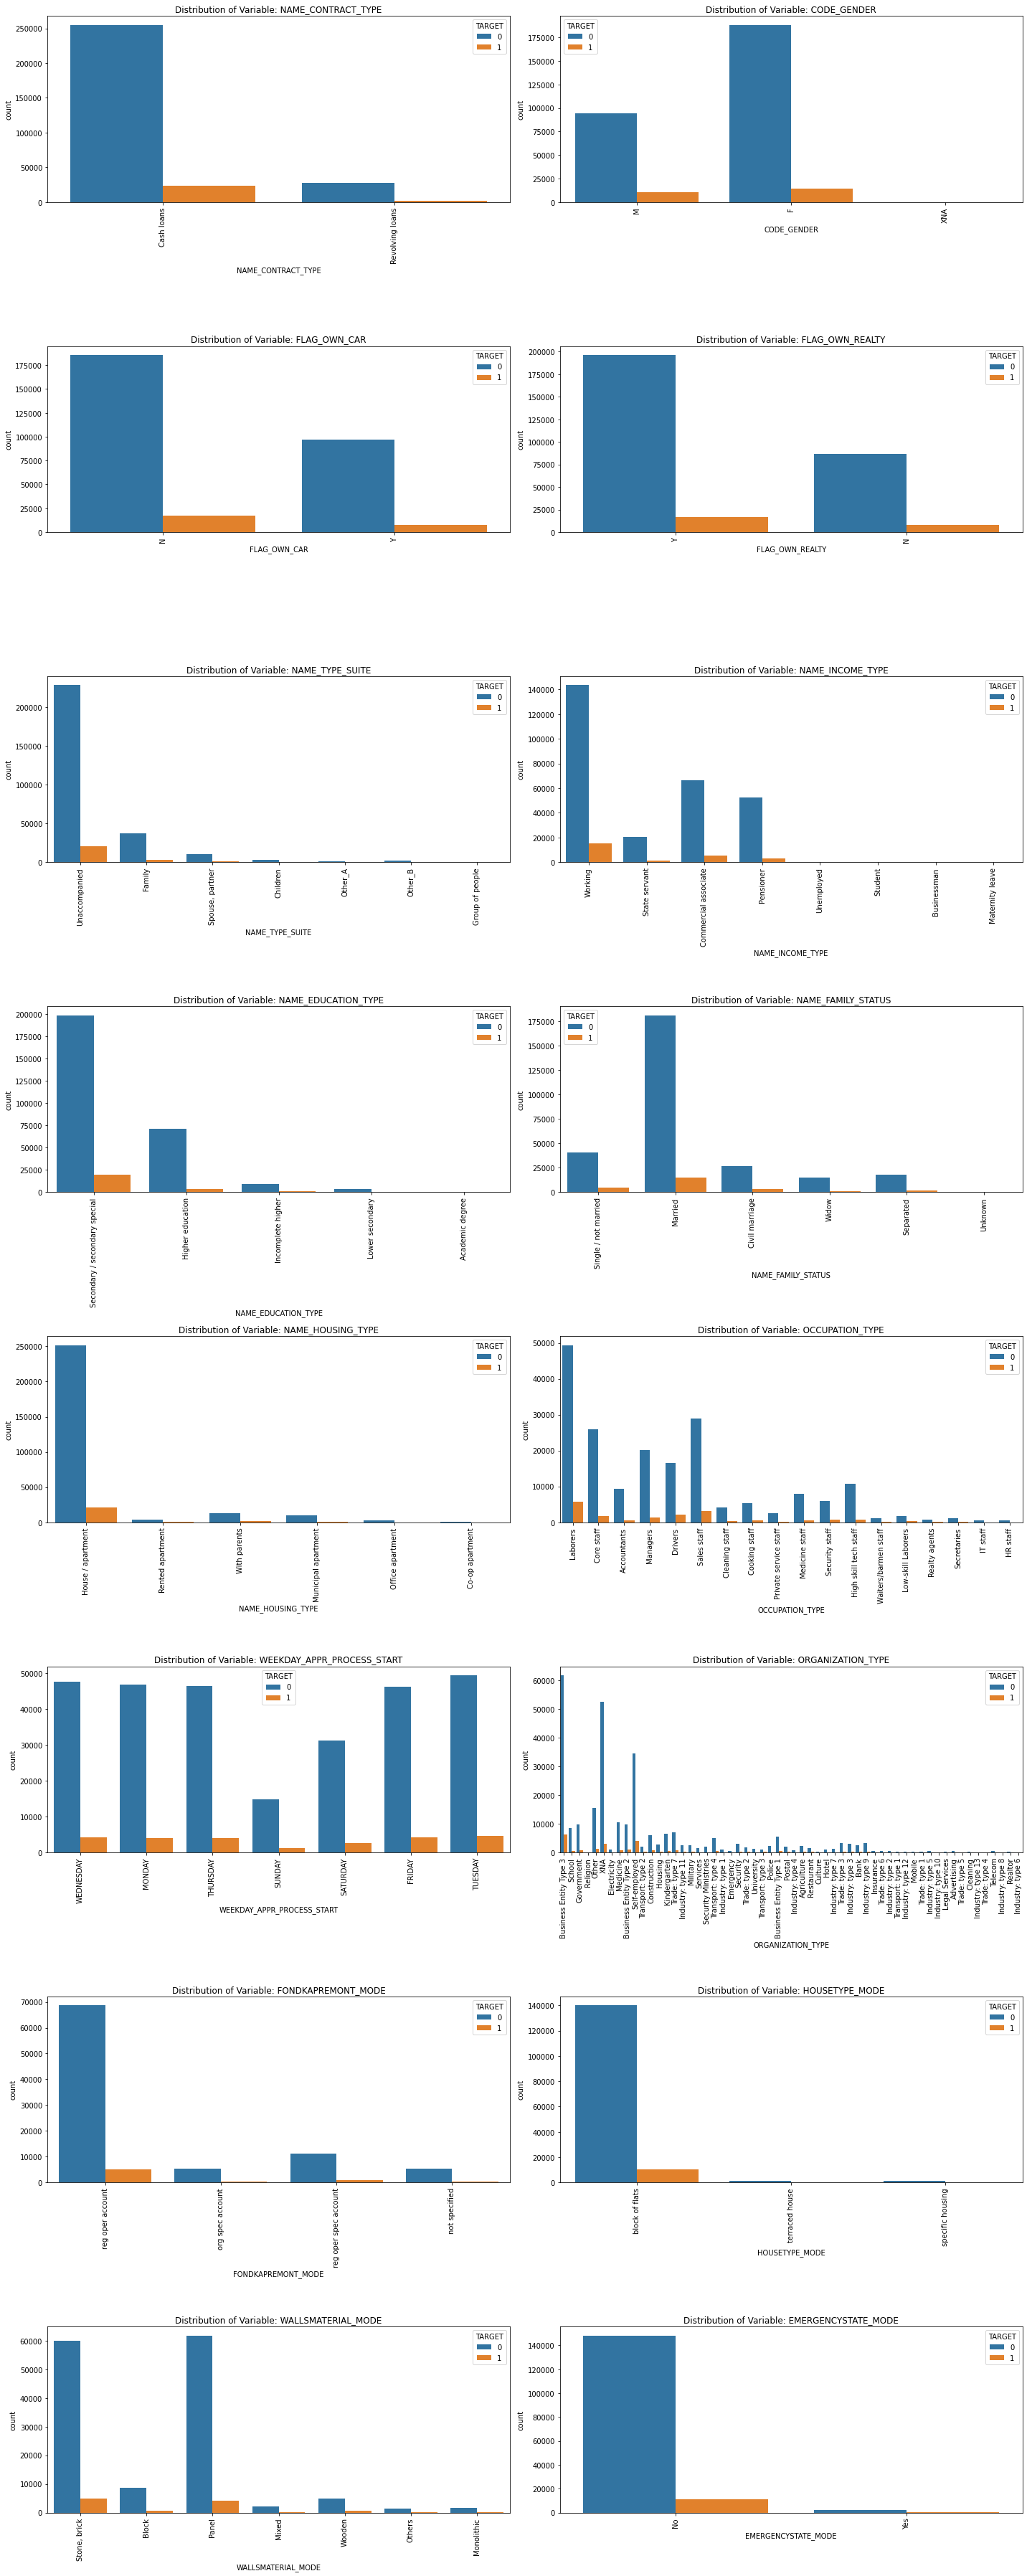

In [16]:
import math
plt.figure(figsize=(10,12)),

fig_rows = math.ceil(selected_cat_features_len/2)
fig, ax = plt.subplots(fig_rows, 2, figsize = (20,50))
col_index = 0
    
for idx, cat in enumerate(selected_cat_features):
    plt.subplot(fig_rows, 2, idx+1)
    sns.countplot(train[cat], hue=train['TARGET'])
    plt.title(f"Distribution of Variable: {cat}")
    plt.xticks(rotation=90)
    plt.tight_layout()

Based on the the above histograms, the following categorical variables will be dropped: 
- 'NAME_TYPE_SUITE' - Who accompanied client when applying for the previous application doesn't really affect ability to pay
- 'NAME_HOUSING_TYPE' - Majority of people live in either house or apartment
- 'WEEKDAY_APPR_PROCESS_START'- Which day of the week a client applied for the loan doesn't really affect ability to pay
- 'FONDKAPREMONT' - Distribution appears similar across all segments
- 'HOUSETYPE_MODE' - Almost all applications are from 'block of flats'
- 'WALLSMATERIAL_MODE' - Almost all wall materials are stone,brick or Panel
- 'EMERGENCYSTATE_MODE' - Almost all applications were not emergency state mode
- 'ORGANIZATION_TYPE'- Appears most organization types have relatively balanced proportions of paid and not paid loans. Also, this can be assumed to have a high correlation with occupation type. 
- 'NAME_INCOME_TYPE' - Presumably has high correlation with 'OCCUPATION' and multiple empty categories

In [17]:
inputs_to_drop = ['NAME_TYPE_SUITE', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START', 
                  'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE','ORGANIZATION_TYPE','NAME_INCOME_TYPE']

for input_var in inputs_to_drop: 
    selected_cat_features.remove(input_var)
    
print("Updated Categorical Columns based on Histograms of Distributions".upper())    
print("-------------------------------------------------------------------------------------")
for col in selected_cat_features:
    print(col)
    
print(f"\n# of Variables Listed Above Minus: {len(selected_cat_features)}") 

UPDATED CATEGORICAL COLUMNS BASED ON HISTOGRAMS OF DISTRIBUTIONS
-------------------------------------------------------------------------------------
NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
OCCUPATION_TYPE

# of Variables Listed Above Minus: 7


### Final Selected Numerical and Categorical Features in Application Training Set

In [18]:
print("Final Features Selected from Application Training Set: ")
print()
print('NUMERICAL FEATURES: ')
print('----------------------')
for col in selected_num_features: 
    print(col)
print(f"\n# of Variables Listed Above: {len(selected_num_features)}") 
print()
print()
print('CATEGORICAL FEATURES: ')
print('----------------------')
for col in selected_cat_features: 
    print(col)
print(f"\n# of Variables Listed Above: {len(selected_cat_features)}") 

Final Features Selected from Application Training Set: 

NUMERICAL FEATURES: 
----------------------
EXT_SOURCE_3
EXT_SOURCE_2
EXT_SOURCE_1
DAYS_BIRTH
REGION_RATING_CLIENT_W_CITY
DAYS_LAST_PHONE_CHANGE
DAYS_ID_PUBLISH
REG_CITY_NOT_WORK_CITY
AMT_INCOME_TOTAL
AMT_CREDIT

# of Variables Listed Above: 10


CATEGORICAL FEATURES: 
----------------------
NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
OCCUPATION_TYPE

# of Variables Listed Above: 7


## Feature Selection for Other Datasets

In [13]:
def all_agg(df, group, aggs, cat = False, num = False):
    feats = df.columns.to_list()
    if "SK_ID_PREV" in feats:
        feats.remove("SK_ID_PREV")
    if "SK_ID_CURR" in feats:
        feats.remove("SK_ID_CURR")
    if "SK_ID_BUREAU" in feats:
        feats.remove("SK_ID_BUREAU")
    new_df = pd.DataFrame()
    for c in feats:
        if df[c].dtype == 'O' and cat:
            col_name = "__".join([c,"mode"])
            tmp_col = df.groupby(group)[[c]].agg(pd.Series.mode).explode(c).rename(columns={c:col_name})
            #display(tmp_col)
            #display(new_df)
            if group[0] not in new_df.index.names:
                new_df = tmp_col
            else:
                new_df = pd.merge(new_df, tmp_col, on=group)
            new_df = pd.get_dummies(new_df, columns = [col_name])
        elif num:
            for agg in aggs:
                tmp_col = df.groupby(group)[c].agg(agg)
                new_df["__".join([c,agg])] = tmp_col
        #display(new_df)
    return new_df

def find_corrs(main_df, join_df, group, join, aggs, cat = False, num = False):
    df_aggs = all_agg(join_df, group, aggs, cat = cat, num = num)
    #display(df_aggs)
    new_t2 = pd.merge(main_df, df_aggs, on=join)
    corrs = new_t2.corr()
    #display(corrs[(corrs.TARGET.abs() > 0.05) & (corrs.TARGET != 1)].sort_values(by="TARGET", key=abs, ascending=False))
    corrs2 = corrs[(corrs.TARGET.abs() > 0.05) & (corrs.TARGET != 1)].sort_values(by="TARGET", key=abs, ascending=False)
    display(corrs2.loc[:,["TARGET"]+corrs2.index.to_list()].style.background_gradient(cmap="coolwarm"))
    return corrs

In [14]:
train = datasets['application_train']
new_t = train.set_index("SK_ID_CURR")
aggs = [
    "mean",
    "median",
    "std",
]
ccb = datasets['credit_card_balance']
ip = datasets['installments_payments']
bb = datasets['bureau_balance']
pos = datasets['POS_CASH_balance']
b = datasets['bureau']
pa = datasets['previous_application']
group = ["SK_ID_CURR","SK_ID_PREV"]
join = ["SK_ID_CURR"]

print("\n----------Credit Card Balance-----------")
ccb_corrs = find_corrs(new_t, ccb, group, join, aggs, cat = True, num = True)

# print("\n-----------Installments Payments-----------")
# ip_corrs = find_corrs(new_t, ip, group, join, aggs, cat = True, num = True)

# print("\n-----------POS Cash Balance-----------")
# pos_corrs = find_corrs(new_t, pos, group, join, aggs, cat = True, num = True)

# print("\n-----------Previous Application-----------")
# cols = pa.columns.to_list()[2:]
# cols1 = ["SK_ID_CURR"]+cols[:10]
# cols2 = ["SK_ID_CURR"]+cols[10:20]
# cols3 = ["SK_ID_CURR"]+cols[20:30]
# cols4 = ["SK_ID_CURR"]+cols[30:]
# pa_corrs1 = find_corrs(new_t.loc[:,["TARGET"]], pa.loc[:, cols1], join, join, aggs, cat = True, num = True)
# pa_corrs2 = find_corrs(new_t.loc[:,["TARGET"]], pa.loc[:, cols2], join, join, aggs, cat = True, num = True)
# pa_corrs3 = find_corrs(new_t.loc[:,["TARGET"]], pa.loc[:, cols3], join, join, aggs, cat = True, num = True)
# pa_corrs4 = find_corrs(new_t.loc[:,["TARGET"]], pa.loc[:, cols4], join, join, aggs, cat = True, num = True)

# bb_aggs = all_agg(bb, ["SK_ID_BUREAU"],aggs)
# b_bb = pd.merge(b, bb, on=["SK_ID_BUREAU"])

# print("\n-----------Bureau and Bureau Balance-----------")
# b_bb_corrs = find_corrs(new_t, b_bb, join, join, aggs, cat = True, num = True)


----------Credit Card Balance-----------


,TARGET,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,CNT_DRAWINGS_CURRENT__std,CNT_DRAWINGS_ATM_CURRENT__mean,CNT_DRAWINGS_ATM_CURRENT__std,AMT_BALANCE__mean,AMT_TOTAL_RECEIVABLE__mean,AMT_RECIVABLE__mean,AMT_RECEIVABLE_PRINCIPAL__mean,AMT_BALANCE__median,AMT_TOTAL_RECEIVABLE__median,AMT_RECIVABLE__median,AMT_RECEIVABLE_PRINCIPAL__median,CNT_DRAWINGS_CURRENT__mean,CNT_DRAWINGS_POS_CURRENT__std,AMT_INST_MIN_REGULARITY__mean,AMT_INST_MIN_REGULARITY__median,DAYS_LAST_PHONE_CHANGE,AMT_DRAWINGS_CURRENT__std,AMT_INST_MIN_REGULARITY__std,DAYS_BIRTH,CNT_DRAWINGS_ATM_CURRENT__median,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,MONTHS_BALANCE__median,MONTHS_BALANCE__mean,MONTHS_BALANCE__std,AMT_DRAWINGS_ATM_CURRENT__mean,AMT_BALANCE__std,AMT_TOTAL_RECEIVABLE__std,AMT_RECIVABLE__std,AMT_DRAWINGS_CURRENT__mean,AMT_RECEIVABLE_PRINCIPAL__std,AMT_DRAWINGS_ATM_CURRENT__std,CNT_DRAWINGS_POS_CURRENT__mean,CNT_DRAWINGS_CURRENT__median
EXT_SOURCE_3,-0.180681,1.000000,0.106057,0.162108,-0.156684,-0.086381,-0.099153,-0.122542,-0.122035,-0.122028,-0.121725,-0.117386,-0.116902,-0.116899,-0.116877,-0.114094,-0.125766,-0.111202,-0.105963,-0.079948,-0.115642,-0.101942,-0.161690,-0.042932,-0.016278,-0.017234,-0.090566,-0.090561,0.091060,-0.049408,-0.091825,-0.091540,-0.091538,-0.090780,-0.090710,-0.061690,-0.082939,-0.069632
EXT_SOURCE_2,-0.159422,0.106057,1.000000,0.214088,-0.080439,-0.066785,-0.073633,-0.010585,-0.009993,-0.009998,-0.009827,-0.015345,-0.014888,-0.014890,-0.014911,-0.057432,-0.074742,0.001071,-0.006108,-0.227461,-0.007653,0.012515,-0.096562,-0.038217,-0.298449,-0.302733,-0.092699,-0.092710,0.091550,-0.011674,0.016684,0.017121,0.017113,-0.003348,0.017583,-0.007281,-0.051644,-0.033820
EXT_SOURCE_1,-0.158306,0.162108,0.214088,1.000000,-0.147444,-0.104806,-0.110330,-0.029359,-0.028536,-0.028544,-0.028478,-0.035111,-0.034433,-0.034442,-0.034580,-0.111744,-0.157258,-0.013061,-0.020355,-0.154959,-0.032163,-0.001813,-0.571575,-0.059745,-0.132089,-0.131313,-0.160193,-0.160190,0.160360,-0.036532,0.001996,0.002616,0.002610,-0.028628,0.003014,-0.027202,-0.113626,-0.071203
CNT_DRAWINGS_CURRENT__std,0.108180,-0.156684,-0.080439,-0.147444,1.000000,0.258014,0.239769,0.354729,0.353223,0.353240,0.354694,0.319643,0.318098,0.318109,0.319556,0.875847,0.966581,0.324174,0.285511,0.115219,0.445250,0.363390,0.174243,0.161703,0.015550,0.019396,0.256920,0.256921,-0.250979,0.143271,0.367066,0.366075,0.366096,0.524434,0.367189,0.099995,0.845424,0.669877
CNT_DRAWINGS_ATM_CURRENT__mean,0.107873,-0.086381,-0.066785,-0.104806,0.258014,1.000000,0.843898,0.406416,0.400297,0.400320,0.398521,0.380670,0.375282,0.375295,0.374392,0.230180,0.077023,0.346456,0.319932,0.109735,0.407788,0.362040,0.060723,0.837043,0.014751,0.010600,0.349188,0.349190,-0.357435,0.732956,0.360837,0.357406,0.357435,0.458152,0.352862,0.540095,0.050337,0.178797
CNT_DRAWINGS_ATM_CURRENT__std,0.106507,-0.099153,-0.073633,-0.110330,0.239769,0.843898,1.000000,0.433061,0.428695,0.428714,0.425694,0.390277,0.386648,0.386659,0.384989,0.125427,0.011965,0.408987,0.364922,0.083487,0.472352,0.402642,0.064313,0.440191,0.018949,0.016084,0.285528,0.285529,-0.285323,0.627969,0.379111,0.376354,0.376376,0.349548,0.370742,0.658822,-0.027729,0.038688
AMT_BALANCE__mean,0.087029,-0.122542,-0.010585,-0.029359,0.354729,0.406416,0.433061,1.000000,0.999954,0.999960,0.999833,0.959353,0.959060,0.959065,0.958971,0.294765,0.150308,0.977678,0.930978,0.010939,0.693580,0.802539,0.060846,0.247112,-0.032591,-0.031649,0.128843,0.128843,-0.126227,0.455342,0.739882,0.741118,0.741123,0.565182,0.739133,0.543677,0.114577,0.210551
AMT_TOTAL_RECEIVABLE__mean,0.086344,-0.122035,-0.009993,-0.028536,0.353223,0.400297,0.428695,0.999954,1.000000,0.999999,0.999875,0.959333,0.959123,0.959121,0.959027,0.293167,0.149622,0.978352,0.931601,0.010065,0.692646,0.802181,0.060308,0.241613,-0.032828,-0.031847,0.126762,0.126762,-0.124205,0.451547,0.739535,0.740824,0.740824,0.563133,0.738864,0.541740,0.113990,0.209179
AMT_RECIVABLE__mean,0.086331,-0.122028,-0.009998

In [ ]:
pd.merge(new_t.loc[:,["TARGET"]],pa.loc[:, cols4], on = ["SK_ID_CURR"])

In [77]:
def returnTop5Corrs(cm):
    corrs = pd.DataFrame(cm.corr()['TARGET']).rename(columns={'TARGET':'corr'})
    corrs['abs_corr'] = corrs.abs()
    top_5_corrs = corrs.sort_values('abs_corr', ascending=False).head(6)
    return top_5_corrs

def topCorrsHeatmap(cm):
    top_5_corrs = returnTop5Corrs(cm)
    features = list(top_5_corrs.index)
    features_df = cm[features]
    features_cm = features_df.corr()
    
    #Plot Correlation Matrix as a heatmap
    mask = np.triu(features_cm)
    
    plt.figure(figsize=(10,10))
    sns.heatmap(features_cm, cmap=plt.cm.coolwarm, annot=True, mask=mask )
    plt.title(f"Correlation Heatmap of Top Correlated Features to Target")
    plt.show()
    
    return features_cm

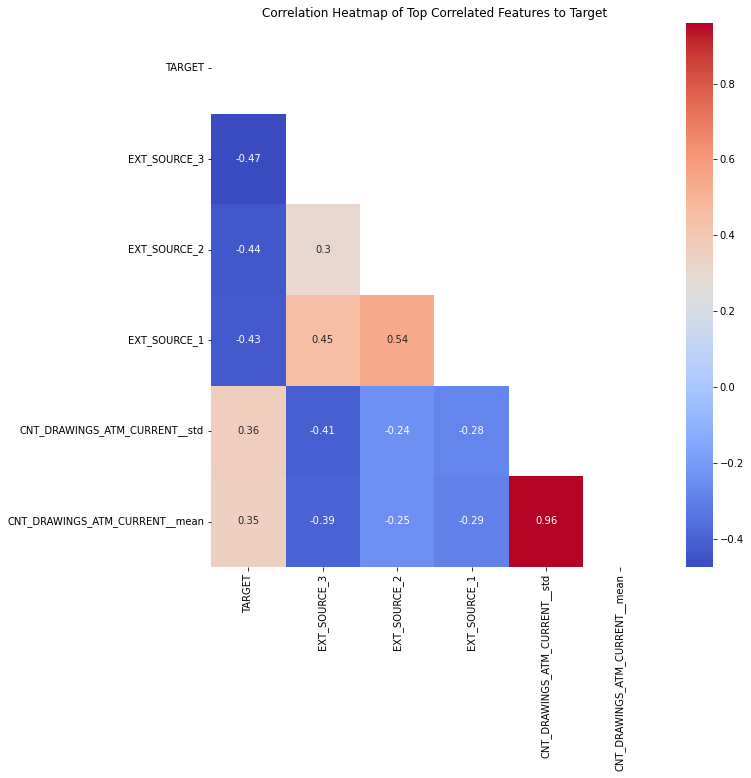


Absolute Correlations > 0.7 Pearson Coefficent:
                                                              Correlation Factor
CNT_DRAWINGS_ATM_CURRENT__mean CNT_DRAWINGS_ATM_CURRENT__std            0.959547



,,Correlation Factor,Feature 1 Correlation with Target,Feature 2 Correlation with Target
CNT_DRAWINGS_ATM_CURRENT__mean,CNT_DRAWINGS_ATM_CURRENT__std,0.959547,0.354291,0.362669


In [79]:
# other_data_cms = [ccb_corrs, ip_corrs, pos_corrs, pa_corrs1, pa_corrs2, pa_corrs3, pa_corrs4, b_bb_corrs] 

other_data_cms = [ccb_corrs]
for cm in other_data_cms: 
    top_5_corrs = returnTop5Corrs(cm)

    #Get features cm and display heatmap
    features_cm = topCorrsHeatmap(cm)

    top_abs_corrs = pd.DataFrame(get_top_abs_correlations(features_cm))
    print("\nAbsolute Correlations > 0.7 Pearson Coefficent:")
    top_abs_corrs.columns = ['Correlation Factor']
    print(top_abs_corrs)
    print()

    top_abs_corrs ['Feature 1 Correlation with Target']=0
    top_abs_corrs ['Feature 2 Correlation with Target']=0
    i=0

    for feature in top_abs_corrs.index:
        top_abs_corrs ['Feature 1 Correlation with Target'].iloc[i] = features_cm['TARGET'].loc[feature[0]]
        top_abs_corrs ['Feature 2 Correlation with Target'].iloc[i] = features_cm['TARGET'].loc[feature[1]]
        i+=1

    display(top_abs_corrs)

    

In [81]:
ccb_sel_features = ['EXT_SOURCE_3','EXT_SOURCE_2','EXT_SOURCE_1', 'CNT_DRAWINGS_ATM_CURRENT_std']

# Baseline Experiments

In [19]:
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from time import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

In [20]:
#Table to track experimental results
try:
    expLog
except NameError:

    expLog = pd.DataFrame(columns=["Experiment Number",
                                   "Model",
                                   "# Transformed Input Features",
                                   "# Original Numerical Features",
                                   "# Original Categorical Features",
                                   "Train Acc",
                                   "Valid Acc",
                                   "Test Acc",
                                   "Train F1",
                                   "Valid F1",    
                                   "Test F1",
                                   "Train AUROC",
                                   "Valid AUROC",                                   
                                   "Test AUROC",                                 
                                   "Training Time",
                                   "Training Prediction Time",
                                   "Validation Prediction Time",
                                   "Test Prediction Time",
                                   "Hyperparameters",
                                   "Best Parameter",
                                   "Best Hypertuning Score",
                                   "Description"])

display(expLog)


,Experiment Number,Model,# Transformed Input Features,# Original Numerical Features,# Original Categorical Features,Train Acc,Valid Acc,Test Acc,Train F1,Valid F1,...,Valid AUROC,Test AUROC,Training Time,Training Prediction Time,Validation Prediction Time,Test Prediction Time,Hyperparameters,Best Parameter,Best Hypertuning Score,Description


In [21]:
# Function to train models
def train_model(df, exp_name, num_features, cat_features, pipeline):
    
    features = num_features + cat_features

    # Split data into Train, Test, and Validation Sets
    y = train['TARGET']
    X = train[features]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    print(f"X train           shape: {X_train.shape}")
    print(f"X validation      shape: {X_valid.shape}")
    print(f"X test            shape: {X_test.shape}")
    
    
    print("\nPERFORMING TRAINING: {exp_name}")
    print("\tPipeline:",[name for name, _ in pipeline.steps])
    print("\t# Total Features: ", len(features))
    
    print("\nNumerical Features:")
    print(num_features)
    print("\t# Numerical Features: ", len(num_features))

    print("\nCategorical Features:")
    print(cat_features)
    print("\t# Categorical Features: ", len(cat_features))

    print('\ntraining in progress...')

    #Fit the baseline pipeline to Training data
    start=time()
    model = pipeline.fit(X_train, y_train)
    train_time = np.round(time() - start, 4)
    print(f"\nBaseline Experiment with Original {len(features)} Input Variables - Training Time: %0.3fs" % (train_time))
    
    return features, X_train, X_valid, X_test, y_train, y_valid, y_test, model, train_time

In [22]:
from sklearn.metrics import confusion_matrix

#Function to predict and score trained models
def predict_and_score(X, y, model, model_ID):
    start = time()
    y_pred = model.predict(X)
    pred_time = time() - start
    
    print("\tPrediction Time: %0.3fs" % (pred_time))
    
    acc = accuracy_score(y, y_pred)
    print("\tAccuracy Score: ", acc)
    
    f1 = f1_score(y, y_pred)
    print("\tF1 Score: ", f1)
    
    auroc = roc_auc_score(y, model.predict_proba(X)[:, 1])
    print("\tAUROC Score: ", auroc)
    
    print("\tConfusion Matrix:")
    class_labels = ["0: Repaid","1: Not Repaid"]
    cm = confusion_matrix(y,y_pred).astype(np.float32)
    cm /= cm.sum(axis=1)[:, np.newaxis]
    cm_plot = sns.heatmap(cm, vmin=0, vmax=1, annot=True, cmap="Reds")
    plt.xlabel("Predicted", fontsize=13)
    plt.ylabel("True", fontsize=13)
    cm_plot.set(xticklabels=class_labels, yticklabels=class_labels)
    plt.title(model_ID, fontsize=13)
    plt.show()

    return (cm, y_pred, pred_time, acc, f1, auroc)

## Data Preprocessing Pipelines

### Level 3 Pipelines

In [23]:
# Pipeline for the numeric features.
# Use StandardScaler() to standardize the data, Missing values will be imputed using the feature mean.
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler(with_mean=False))
])


# Pipeline for the categorical features.
# Entries with missing values or values that don't exist in the range defined above will be one hot encoded as zeroes.
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value= 'missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


### Level 2 Pipeline

In [24]:
#features_pipeline to combine Numerical and Categorical Pipelines
data_pipeline_17 = ColumnTransformer(
    transformers= [
        ('num', num_pipeline, selected_num_features), 
        ('cat', cat_pipeline, selected_cat_features)],
        remainder='drop',
        n_jobs=-1
    )

# Baseline Experiment
baseline_pipeline_17 = Pipeline([
        ("preparation", data_pipeline_17),
        ("logRegression", LogisticRegression())
    ])

#Name of Experiment
exp_name = "Baseline 1, LogReg with Original 17 Selected Features"

#Description of Experiments
description = 'Baseline 1 LogReg Model with Preselected Num and Cat Features.'

#Start Experiment count for the expLog
exp_count = 1

## Baseline Experiment (Level 1 Pipeline) with 22 Selected Features in application_train


In [25]:
features, X_train, X_valid, X_test, y_train, y_valid, y_test, model, train_time = train_model(train, exp_name, selected_num_features, selected_cat_features, baseline_pipeline_17)

X train           shape: (209107, 17)
X validation      shape: (52277, 17)
X test            shape: (46127, 17)

PERFORMING TRAINING: {exp_name}
	Pipeline: ['preparation', 'logRegression']
	# Total Features:  17

Numerical Features:
['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'DAYS_BIRTH', 'REGION_RATING_CLIENT_W_CITY', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'REG_CITY_NOT_WORK_CITY', 'AMT_INCOME_TOTAL', 'AMT_CREDIT']
	# Numerical Features:  10

Categorical Features:
['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'OCCUPATION_TYPE']
	# Categorical Features:  7

training in progress...

Baseline Experiment with Original 17 Input Variables - Training Time: 6.436s


### Prediction and Scoring

Baseline Experiment with 49 Variables - Training Set:
	Prediction Time: 1.037s
	Accuracy Score:  0.9198352996312893
	F1 Score:  0.013534984993820987
	AUROC Score:  0.7372723658637548
	Confusion Matrix:


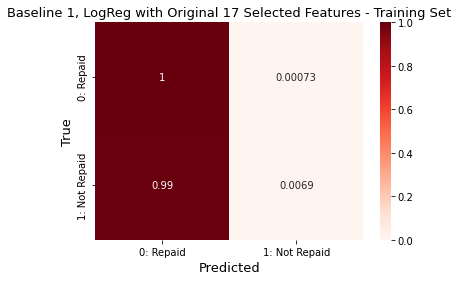

Baseline Experiment with 49 Variables - Validation Set:
	Prediction Time: 0.266s
	Accuracy Score:  0.9164068328327946
	F1 Score:  0.015322217214961693
	AUROC Score:  0.7379017943159354
	Confusion Matrix:


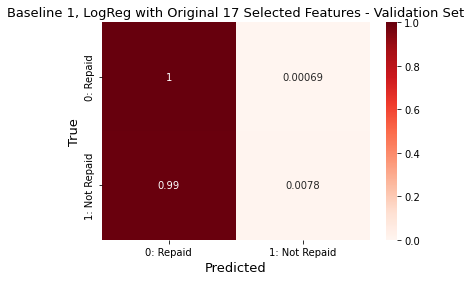

Baseline Experiment with 49 Variables - Test Set:
	Prediction Time: 0.259s
	Accuracy Score:  0.9190062219524356
	F1 Score:  0.01059322033898305
	AUROC Score:  0.7367988626090529
	Confusion Matrix:


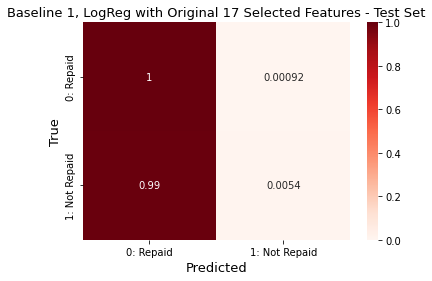

In [26]:
X_train_transformed_17 = data_pipeline_17.fit_transform(X_train)
total_inputs_17 = X_train_transformed_17.shape[1]

# Training Set
print(f"Baseline Experiment with {total_inputs_17} Variables - Training Set:")
cm_train, y_pred_train, pred_time_train, train_acc, train_f1, train_auroc= predict_and_score(X_train, y_train, model, exp_name+' - Training Set')

# Validation Set
print(f"Baseline Experiment with {total_inputs_17} Variables - Validation Set:")
cm_valid, y_pred_valid, pred_time_valid, valid_acc, valid_f1, valid_auroc = predict_and_score(X_valid, y_valid, model, exp_name+' - Validation Set')

# Test Set
print(f"Baseline Experiment with {total_inputs_17} Variables - Test Set:")
cm_test, y_pred_test, pred_time_test, test_acc, test_f1, test_auroc= predict_and_score(X_test, y_test, model, exp_name+' - Test Set')

In [27]:
expLog.loc[len(expLog)] = [exp_count, 
                           exp_name, 
                           total_inputs_17,
                           len(selected_num_features),
                           len(selected_cat_features),
                           round(train_acc, 3), 
                           round(valid_acc, 3),
                           round(test_acc,3),
                           round(train_f1, 3), 
                           round(valid_f1, 3),
                           round(test_f1,3),
                           round(train_auroc, 3), 
                           round(valid_auroc, 3),                                                      
                           round(test_auroc,3),                         
                           train_time, 
                           pred_time_train,
                           pred_time_valid,
                           pred_time_test, 
                           "N/A",
                           "N/A",
                           "N/A",
                           description]


display(expLog)


exp_count += 1

,Experiment Number,Model,# Transformed Input Features,# Original Numerical Features,# Original Categorical Features,Train Acc,Valid Acc,Test Acc,Train F1,Valid F1,...,Valid AUROC,Test AUROC,Training Time,Training Prediction Time,Validation Prediction Time,Test Prediction Time,Hyperparameters,Best Parameter,Best Hypertuning Score,Description
0,1,"Baseline 1, LogReg with Original 17 Selected F...",49,10,7,0.92,0.916,0.919,0.014,0.015,...,0.738,0.737,6.4365,1.037167,0.265764,0.259094,N/A,N/A,N/A,Baseline 1 LogReg Model with Preselected Num a...


## Baseline Experiment (Level 1 Pipeline) with all 120 Input Features in application_train

In [28]:
# Input Features excluding SK_ID_CURR and TARGET
all_num_features = train.describe().columns.to_list()
all_cat_features = set(train.columns.to_list()) - set(all_num_features)
all_cat_features = list(all_cat_features)

all_num_features.remove('SK_ID_CURR') #ID has no effect on ability to repay loans
all_num_features.remove('TARGET') 


In [29]:
#features_pipeline to combine Numerical and Categorical Pipelines of all features
data_pipeline_120 = ColumnTransformer(
    transformers= [
        ('num', num_pipeline, all_num_features), 
        ('cat', cat_pipeline, all_cat_features)],
        remainder='drop',
        n_jobs=-1
    )

# Baseline Experiment with 120 Input Vars
baseline_pipeline_120 = Pipeline([
        ("preparation", data_pipeline_120),
        ("logRegression", LogisticRegression())
    ])

#Name of Experiment
exp_name = "Baseline 2, LogReg with original 120 Features"

#Description of Experiments
description = 'Baseline 2 LogReg Model with Num and Cat Features.'

In [30]:
features, X_train, X_valid, X_test, y_train, y_valid, y_test, model, train_time= train_model(train, exp_name, all_num_features, all_cat_features, baseline_pipeline_120)

X train           shape: (209107, 120)
X validation      shape: (52277, 120)
X test            shape: (46127, 120)

PERFORMING TRAINING: {exp_name}
	Pipeline: ['preparation', 'logRegression']
	# Total Features:  120

Numerical Features:
['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLO

### Prediction and Scoring

Baseline Experiment Training Set with 250 Input Features:
	Prediction Time: 2.182s
	Accuracy Score:  0.9198974687600128
	F1 Score:  0.020582388024792418
	AUROC Score:  0.7459129145484819
	Confusion Matrix:


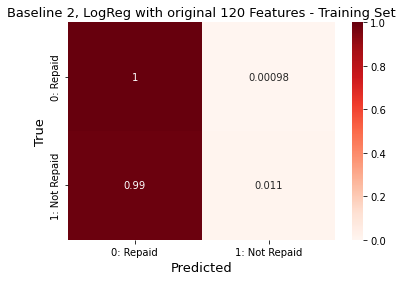

Baseline Experiment Validation Set with 250 Input Features:
	Prediction Time: 0.496s
	Accuracy Score:  0.916311188476768
	F1 Score:  0.01927818874691773
	AUROC Score:  0.7465538185084738
	Confusion Matrix:


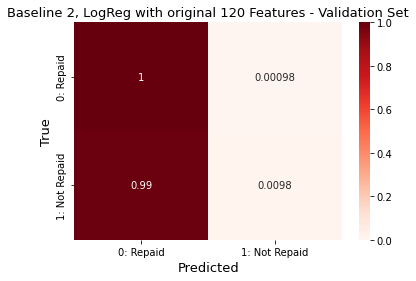

Baseline Experiment Test Set with 250 Input Features:
	Prediction Time: 0.493s
	Accuracy Score:  0.9192446939970083
	F1 Score:  0.022053032291940142
	AUROC Score:  0.7431242422114418
	Confusion Matrix:


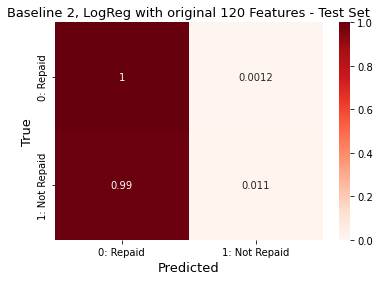

In [31]:
X_train_transformed_120 = data_pipeline_120.fit_transform(X_train)
total_inputs_120 = X_train_transformed_120.shape[1]

# Training Set
print(f"Baseline Experiment Training Set with {total_inputs_120} Input Features:")
cm_train, y_pred_train, pred_time_train, train_acc, train_f1, train_auroc = predict_and_score(X_train, y_train, model, exp_name+' - Training Set')

# Validation Set
print(f"Baseline Experiment Validation Set with {total_inputs_120} Input Features:")
cm_valid, y_pred_valid, pred_time_valid, valid_acc, valid_f1, valid_auroc = predict_and_score(X_valid, y_valid, model, exp_name+' - Validation Set')

# Test Set
print(f"Baseline Experiment Test Set with {total_inputs_120} Input Features:")
cm_test, y_pred_test, pred_time_test, test_acc, test_f1, test_auroc = predict_and_score(X_test, y_test, model, exp_name+' - Test Set')

In [32]:
expLog.loc[len(expLog)] = [exp_count, 
                           exp_name, 
                           total_inputs_120,
                           len(all_num_features),
                           len(all_cat_features),
                           round(train_acc, 3), 
                           round(valid_acc, 3),
                           round(test_acc,3),
                           round(train_f1, 3), 
                           round(valid_f1, 3),
                           round(test_f1,3),
                           round(train_auroc, 3), 
                           round(valid_auroc, 3),                                                      
                           round(test_auroc,3),                         
                           train_time, 
                           pred_time_train,
                           pred_time_valid,
                           pred_time_test, 
                           "N/A",
                           "N/A",
                           "N/A",
                           description]

display(expLog)

exp_count += 1

,Experiment Number,Model,# Transformed Input Features,# Original Numerical Features,# Original Categorical Features,Train Acc,Valid Acc,Test Acc,Train F1,Valid F1,...,Valid AUROC,Test AUROC,Training Time,Training Prediction Time,Validation Prediction Time,Test Prediction Time,Hyperparameters,Best Parameter,Best Hypertuning Score,Description
0,1,"Baseline 1, LogReg with Original 17 Selected F...",49,10,7,0.92,0.916,0.919,0.014,0.015,...,0.738,0.737,6.4365,1.037167,0.265764,0.259094,N/A,N/A,N/A,Baseline 1 LogReg Model with Preselected Num a...
1,2,"Baseline 2, LogReg with original 120 Features",250,104,16,0.92,0.916,0.919,0.021,0.019,...,0.747,0.743,12.8944,2.181616,0.495916,0.493019,N/A,N/A,N/A,Baseline 2 LogReg Model with Num and Cat Featu...


## LogReg Experiment with L1 Penalty with 17 Selected Input Features

In [33]:
# LogReg Experiment with L1 Penalty (L2 is default)
L1_pipeline_17 = Pipeline([
        ("preparation", data_pipeline_17),
        ("lassoRegression", LogisticRegression(penalty='l1', solver = 'saga'))
    ])

#Name of Experiment
exp_name = "LogReg - L1 Penalty with Selected 17 Features"

#Description of Experiments
description = 'LogReg Model-L1 Penalty with Selected 17 Cat + Num Features.'

features, X_train, X_valid, X_test, y_train, y_valid, y_test, model, train_time = train_model(train, exp_name, selected_num_features, selected_cat_features, L1_pipeline_17)

X train           shape: (209107, 17)
X validation      shape: (52277, 17)
X test            shape: (46127, 17)

PERFORMING TRAINING: {exp_name}
	Pipeline: ['preparation', 'lassoRegression']
	# Total Features:  17

Numerical Features:
['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'DAYS_BIRTH', 'REGION_RATING_CLIENT_W_CITY', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'REG_CITY_NOT_WORK_CITY', 'AMT_INCOME_TOTAL', 'AMT_CREDIT']
	# Numerical Features:  10

Categorical Features:
['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'OCCUPATION_TYPE']
	# Categorical Features:  7

training in progress...

Baseline Experiment with Original 17 Input Variables - Training Time: 24.901s


### Prediction and Scoring

LogReg - L1 Penalty Training Set with 49 Input Features:
	Prediction Time: 0.582s
	Accuracy Score:  0.9198400818719603
	F1 Score:  0.0136518771331058
	AUROC Score:  0.7372160260847427
	Confusion Matrix:


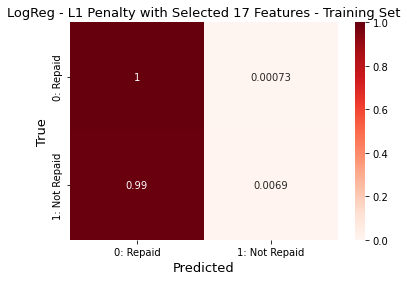

LogReg - L1 Penalty Validation Set with 49 Input Features:
	Prediction Time: 0.235s
	Accuracy Score:  0.9164450905752052
	F1 Score:  0.016216216216216217
	AUROC Score:  0.737986155550196
	Confusion Matrix:


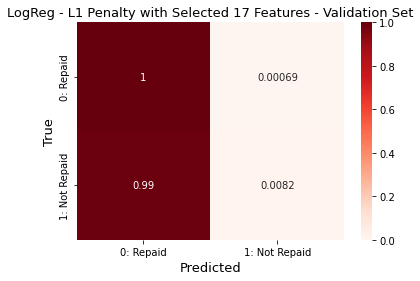

LogReg - L1 Penalty Test Set with 49 Input Features:
	Prediction Time: 0.238s
	Accuracy Score:  0.919027901229215
	F1 Score:  0.011119936457505957
	AUROC Score:  0.7369063874648982
	Confusion Matrix:


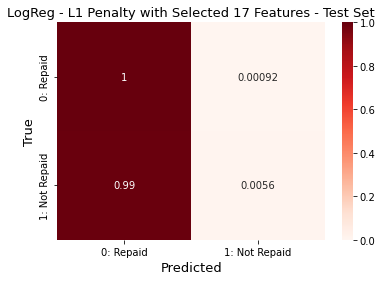

In [34]:

# Training Set
print(f"LogReg - L1 Penalty Training Set with {total_inputs_17} Input Features:")
cm_train, y_pred_train, pred_time_train, train_acc, train_f1, train_auroc = predict_and_score(X_train, y_train, model, exp_name+' - Training Set')

# Validation Set
print(f"LogReg - L1 Penalty Validation Set with {total_inputs_17} Input Features:")
cm_valid, y_pred_valid, pred_time_valid, valid_acc, valid_f1, valid_auroc = predict_and_score(X_valid, y_valid, model, exp_name+' - Validation Set')

# Test Set
print(f"LogReg - L1 Penalty Test Set with {total_inputs_17} Input Features:")
cm_test, y_pred_test, pred_time_test, test_acc, test_f1, test_auroc = predict_and_score(X_test, y_test, model, exp_name+' - Test Set')

In [35]:
expLog.loc[len(expLog)] = [exp_count, 
                           exp_name, 
                           total_inputs_17,
                           len(selected_num_features),
                           len(selected_cat_features),
                           round(train_acc, 3), 
                           round(valid_acc, 3),
                           round(test_acc,3),
                           round(train_f1, 3), 
                           round(valid_f1, 3),
                           round(test_f1,3),
                           round(train_auroc, 3), 
                           round(valid_auroc, 3),                                                      
                           round(test_auroc,3),                         
                           train_time, 
                           pred_time_train,
                           pred_time_valid,
                           pred_time_test, 
                           "N/A",
                           "N/A",
                           "N/A",
                           description]

display(expLog)

exp_count += 1

,Experiment Number,Model,# Transformed Input Features,# Original Numerical Features,# Original Categorical Features,Train Acc,Valid Acc,Test Acc,Train F1,Valid F1,...,Valid AUROC,Test AUROC,Training Time,Training Prediction Time,Validation Prediction Time,Test Prediction Time,Hyperparameters,Best Parameter,Best Hypertuning Score,Description
0,1,"Baseline 1, LogReg with Original 17 Selected F...",49,10,7,0.92,0.916,0.919,0.014,0.015,...,0.738,0.737,6.4365,1.037167,0.265764,0.259094,N/A,N/A,N/A,Baseline 1 LogReg Model with Preselected Num a...
1,2,"Baseline 2, LogReg with original 120 Features",250,104,16,0.92,0.916,0.919,0.021,0.019,...,0.747,0.743,12.8944,2.181616,0.495916,0.493019,N/A,N/A,N/A,Baseline 2 LogReg Model with Num and Cat Featu...
2,3,LogReg - L1 Penalty with Selected 17 Features,49,10,7,0.92,0.916,0.919,0.014,0.016,...,0.738,0.737,24.9009,0.581788,0.235044,0.237610,N/A,N/A,N/A,LogReg Model-L1 Penalty with Selected 17 Cat +...


## LogReg Experiment with L1 Penalty - all 120 Input Features


In [36]:
# LogReg Experiment with L1 Penalty (L2 is default)
L1_pipeline_120 = Pipeline([
        ("preparation", data_pipeline_120),
        ("lassoRegression", LogisticRegression(penalty='l1', solver = 'saga'))
    ])

#Name of Experiment
exp_name = "LogReg - L1 Penalty with 120 Features"

#Description of Experiments
description = 'LogReg Model-L1 Penalty with 104 Num + 16 Cat Features.'

features, X_train, X_valid, X_test, y_train, y_valid, y_test, model, train_time = train_model(train, exp_name, all_num_features, all_cat_features, L1_pipeline_120)


X train           shape: (209107, 120)
X validation      shape: (52277, 120)
X test            shape: (46127, 120)

PERFORMING TRAINING: {exp_name}
	Pipeline: ['preparation', 'lassoRegression']
	# Total Features:  120

Numerical Features:
['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'F

### Prediction and Scoring

LogReg - L1 Penalty Training Set with 250 Input Features:
	Prediction Time: 1.768s
	Accuracy Score:  0.9198735575566576
	F1 Score:  0.016898433374405917
	AUROC Score:  0.7440220032030409
	Confusion Matrix:


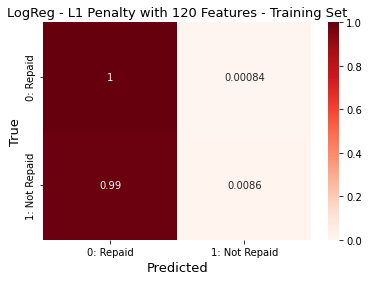

LogReg - L1 Penalty Validation Set with 250 Input Features:
	Prediction Time: 0.484s
	Accuracy Score:  0.916311188476768
	F1 Score:  0.013528748590755355
	AUROC Score:  0.7453249812034192
	Confusion Matrix:


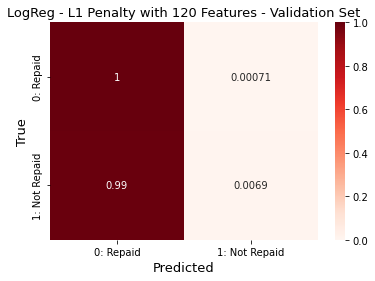

LogReg - L1 Penalty Test Set with 250 Input Features:
	Prediction Time: 0.471s
	Accuracy Score:  0.9192013354434496
	F1 Score:  0.017918313570487485
	AUROC Score:  0.7427358459386402
	Confusion Matrix:


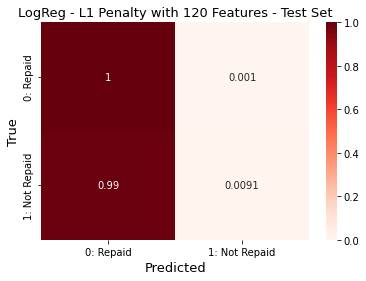

In [37]:
# Training Set
print(f"LogReg - L1 Penalty Training Set with {total_inputs_120} Input Features:")
cm_train, y_pred_train, pred_time_train, train_acc, train_f1, train_auroc = predict_and_score(X_train, y_train, model, exp_name+' - Training Set')

# Validation Set
print(f"LogReg - L1 Penalty Validation Set with {total_inputs_120} Input Features:")
cm_valid, y_pred_valid, pred_time_valid, valid_acc, valid_f1, valid_auroc = predict_and_score(X_valid, y_valid, model, exp_name+' - Validation Set')

# Test Set
print(f"LogReg - L1 Penalty Test Set with {total_inputs_120} Input Features:")
cm_test, y_pred_test, pred_time_test, test_acc, test_f1, test_auroc = predict_and_score(X_test, y_test, model, exp_name+' - Test Set')


In [38]:
expLog.loc[len(expLog)] = [exp_count, 
                           exp_name, 
                           total_inputs_120,
                           len(all_num_features),
                           len(all_cat_features),
                           round(train_acc, 3), 
                           round(valid_acc, 3),
                           round(test_acc,3),
                           round(train_f1, 3), 
                           round(valid_f1, 3),
                           round(test_f1,3),
                           round(train_auroc, 3), 
                           round(valid_auroc, 3),                                                      
                           round(test_auroc,3),                         
                           train_time, 
                           pred_time_train,
                           pred_time_valid,
                           pred_time_test, 
                           "N/A",
                           "N/A",
                           "N/A",
                           description]

display(expLog)

exp_count += 1

,Experiment Number,Model,# Transformed Input Features,# Original Numerical Features,# Original Categorical Features,Train Acc,Valid Acc,Test Acc,Train F1,Valid F1,...,Valid AUROC,Test AUROC,Training Time,Training Prediction Time,Validation Prediction Time,Test Prediction Time,Hyperparameters,Best Parameter,Best Hypertuning Score,Description
0,1,"Baseline 1, LogReg with Original 17 Selected F...",49,10,7,0.92,0.916,0.919,0.014,0.015,...,0.738,0.737,6.4365,1.037167,0.265764,0.259094,N/A,N/A,N/A,Baseline 1 LogReg Model with Preselected Num a...
1,2,"Baseline 2, LogReg with original 120 Features",250,104,16,0.92,0.916,0.919,0.021,0.019,...,0.747,0.743,12.8944,2.181616,0.495916,0.493019,N/A,N/A,N/A,Baseline 2 LogReg Model with Num and Cat Featu...
2,3,LogReg - L1 Penalty with Selected 17 Features,49,10,7,0.92,0.916,0.919,0.014,0.016,...,0.738,0.737,24.9009,0.581788,0.235044,0.237610,N/A,N/A,N/A,LogReg Model-L1 Penalty with Selected 17 Cat +...
3,4,LogReg - L1 Penalty with 120 Features,250,104,16,0.92,0.916,0.919,0.017,0.014,...,0.745,0.743,82.9160,1.767803,0.484229,0.471008,N/A,N/A,N/A,LogReg Model-L1 Penalty with 104 Num + 16 Cat ...


## Log Reg with all 120 Inputs + New Debt_to_Income_Ratio Feature

In [39]:
# All 120 Input Features Plus New Feature Transformation in Pipeline: Debt-to-Income Ratio

from sklearn.base import BaseEstimator, TransformerMixin

class Debt_to_Income_Ratio(BaseEstimator, TransformerMixin):
    def __init__(self, features=None): # no *args or **kargs
        self.features = features
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        df = pd.DataFrame(X.copy(), columns=self.features)  # select a subset of columns in X based on self.features 

        feature1 = 'AMT_CREDIT'
        feature2 = 'AMT_INCOME_TOTAL'
        
        #Create new column for debt-to-income ratio
        df['DEBT_TO_INCOME_RATIO'] = df[feature1] / df[feature2] 
        
        #Drop the features that were initially passed
        df.drop(feature1, axis=1, inplace=True)
        df.drop(feature2, axis=1, inplace=True)
        
        #Return df
        return df
    
    
test_pipeline = make_pipeline(Debt_to_Income_Ratio())
debt_income_ratio = test_pipeline.fit_transform (X_train[['AMT_CREDIT', 'AMT_INCOME_TOTAL']])
display(pd.DataFrame(np.c_[X_train[['AMT_CREDIT', 'AMT_INCOME_TOTAL']],debt_income_ratio], columns=['AMT_CREDIT', 'AMT_INCOME_TOTAL'] + ["DEBT_INCOME_RATIO"]) ) 



,AMT_CREDIT,AMT_INCOME_TOTAL,DEBT_INCOME_RATIO
0,540000.0,144000.0,3.750000
1,1762110.0,225000.0,7.831600
2,161730.0,135000.0,1.198000
3,270000.0,67500.0,4.000000
4,1381113.0,202500.0,6.820311
...,...,...,...
209102,1762110.0,270000.0,6.526333
209103,284400.0,112500.0,2.528000
209104,180000.0,45000.0,4.000000
209105,1736937.0,202500.0,8.577467


In [40]:
data_pipeline_DIR_120 = ColumnTransformer( 
    transformers= [
        # (name, transformer,     columns)
        ('num', num_pipeline, all_num_features),
        ('cat', cat_pipeline, all_cat_features),
        ('DIR', make_pipeline(Debt_to_Income_Ratio(), StandardScaler()), ['AMT_CREDIT', 'AMT_INCOME_TOTAL'])
          
    ],
        remainder='drop',
        n_jobs=-1
    )

X_train_transformed = data_pipeline_DIR_120.fit_transform(X_train)
column_names = all_num_features  + \
               list(data_pipeline_DIR_120.transformers_[1][1].named_steps["onehot"].get_feature_names(all_cat_features)) +\
                ['DEBT_TO_INCOME_RATIO']

display(pd.DataFrame(X_train_transformed,  columns=column_names).head())
number_of_inputs = X_train_transformed.shape[1]

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,DEBT_TO_INCOME_RATIO
0,2.763729,1.355273,1.339199,2.022258,1.459046,1.496970,-2.541537,-0.020777,-1.388585,-1.504414,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,-0.077059
1,1.381865,2.117614,4.370030,3.208587,4.255552,1.778614,-2.978958,-0.021845,-0.473084,-2.666495,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.437253
2,0.000000,1.270568,0.401090,0.785916,0.364762,0.733344,-5.520724,2.583799,-3.407287,-2.883019,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,-1.023874
3,0.000000,0.635284,0.669600,0.961737,0.729523,2.222725,-4.295578,-0.034366,-2.235083,-1.503752,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.015694
4,0.000000,1.905853,3.425158,2.630799,3.258537,2.222725,-2.070415,-0.010463,-1.092978,-0.992569,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.062055


In [41]:
# Baseline Experiment with 120 Input Vars
baseline_pipeline_DIR_120 = Pipeline([
        ("preparation", data_pipeline_DIR_120),
        ("logRegression", LogisticRegression())
    ])

#Name of Experiment)
exp_name = "LogReg with Num and Cat Features + Debt_Income_Ratio"

#Description of Experiments
description =" Logistic Regression Model with Original 120 Num and Cat Features + Debt-Income-Ratio."


In [42]:

features, X_train, X_valid, X_test, y_train, y_valid, y_test, model, train_time = train_model(train, exp_name, all_num_features, all_cat_features, baseline_pipeline_DIR_120)

X train           shape: (209107, 120)
X validation      shape: (52277, 120)
X test            shape: (46127, 120)

PERFORMING TRAINING: {exp_name}
	Pipeline: ['preparation', 'logRegression']
	# Total Features:  120

Numerical Features:
['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLO

### Prediction and Scoring

Baseline Experiment Training Set with all 120 input features + Added Debt-Income-Ratio Feature:
	Prediction Time: 1.704s
	Accuracy Score:  0.9198352996312893
	F1 Score:  0.020566754309085597
	AUROC Score:  0.7453769118854485
	Confusion Matrix:


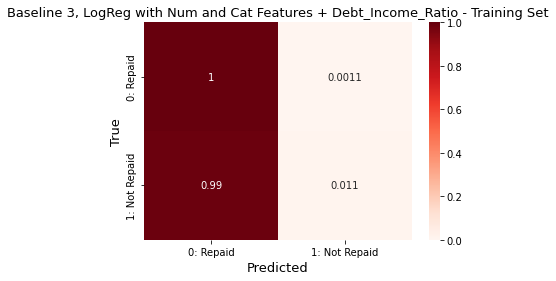

Baseline Experiment Validation Set with all 120 input features + Added Debt-Income-Ratio Feature:
	Prediction Time: 0.513s
	Accuracy Score:  0.9161198997647149
	F1 Score:  0.01791713325867861
	AUROC Score:  0.7456784531035063
	Confusion Matrix:


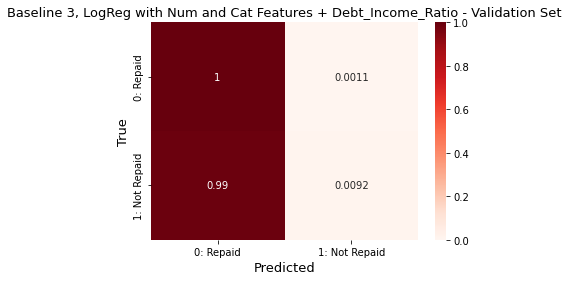

Baseline Experiment Test Set with all 120 input features + Added Debt-Income-Ratio Feature:
	Prediction Time: 0.472s
	Accuracy Score:  0.9192013354434496
	F1 Score:  0.02255441909257802
	AUROC Score:  0.743045238402905
	Confusion Matrix:


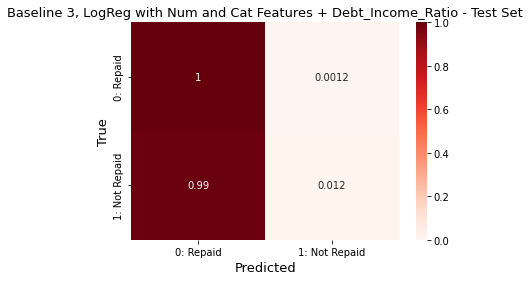

In [43]:
total_inputs = X_train_transformed.shape[1]

# Training Set
print(f"Training Set with all 120 input features + Added Debt-Income-Ratio Feature:")
cm_train, y_pred_train, pred_time_train, train_acc, train_f1, train_auroc = predict_and_score(X_train, y_train, model, exp_name+' - Training Set')

# Validation Set
print(f"Validation Set with all 120 input features + Added Debt-Income-Ratio Feature:")
cm_valid, y_pred_valid, pred_time_valid, valid_acc, valid_f1, valid_auroc = predict_and_score(X_valid, y_valid, model, exp_name+' - Validation Set')

# Test Set
print(f"Test Set with all 120 input features + Added Debt-Income-Ratio Feature:")
cm_test, y_pred_test, pred_time_test, test_acc, test_f1, test_auroc = predict_and_score(X_test, y_test, model, exp_name+' - Test Set')

In [44]:
expLog.loc[len(expLog)] = [exp_count, 
                           exp_name, 
                           total_inputs,
                           len(all_num_features),
                           len(all_cat_features),
                           round(train_acc, 3), 
                           round(valid_acc, 3),
                           round(test_acc, 3),
                           round(train_f1, 3), 
                           round(valid_f1, 3),
                           round(test_f1, 3),
                           round(train_auroc, 3),                          
                           round(valid_auroc, 3),                                                     
                           round(test_auroc,3),                           
                           train_time, 
                           pred_time_train,
                           pred_time_valid,
                           pred_time_test, 
                           "N/A",
                           "N/A",
                           "N/A",
                           description]

display(expLog)

exp_count += 1

,Experiment Number,Model,# Transformed Input Features,# Original Numerical Features,# Original Categorical Features,Train Acc,Valid Acc,Test Acc,Train F1,Valid F1,...,Valid AUROC,Test AUROC,Training Time,Training Prediction Time,Validation Prediction Time,Test Prediction Time,Hyperparameters,Best Parameter,Best Hypertuning Score,Description
0,1,"Baseline 1, LogReg with Original 17 Selected F...",49,10,7,0.92,0.916,0.919,0.014,0.015,...,0.738,0.737,6.4365,1.037167,0.265764,0.259094,N/A,N/A,N/A,Baseline 1 LogReg Model with Preselected Num a...
1,2,"Baseline 2, LogReg with original 120 Features",250,104,16,0.92,0.916,0.919,0.021,0.019,...,0.747,0.743,12.8944,2.181616,0.495916,0.493019,N/A,N/A,N/A,Baseline 2 LogReg Model with Num and Cat Featu...
2,3,LogReg - L1 Penalty with Selected 17 Features,49,10,7,0.92,0.916,0.919,0.014,0.016,...,0.738,0.737,24.9009,0.581788,0.235044,0.237610,N/A,N/A,N/A,LogReg Model-L1 Penalty with Selected 17 Cat +...
3,4,LogReg - L1 Penalty with 120 Features,250,104,16,0.92,0.916,0.919,0.017,0.014,...,0.745,0.743,82.9160,1.767803,0.484229,0.471008,N/A,N/A,N/A,LogReg Model-L1 Penalty with 104 Num + 16 Cat ...
4,5,"Baseline 3, LogReg with Num and Cat Features +...",251,104,16,0.92,0.916,0.919,0.021,0.018,...,0.746,0.743,11.6482,1.703953,0.512874,0.471745,N/A,N/A,N/A,Logistic Regression Model with Original 120 N...


## Log Reg with Selected 17 Inputs + New Debt_to_Income_Ratio Feature

In [45]:
data_pipeline_DIR_17 = ColumnTransformer( 
    transformers= [
        # (name, transformer,     columns)
        ('num', num_pipeline, selected_num_features),
        ('cat', cat_pipeline, selected_cat_features),
        ('DIR', make_pipeline(Debt_to_Income_Ratio(), StandardScaler()), ['AMT_CREDIT', 'AMT_INCOME_TOTAL'])
          
    ],
        remainder='drop',
        n_jobs=-1
    )

baseline_pipeline_DIR_17 = Pipeline([
        ("preparation", data_pipeline_DIR_17),
        ("logRegression", LogisticRegression())
    ])


X_train_transformed = data_pipeline_DIR_17.fit_transform(X_train)
total_inputs = X_train_transformed.shape[1]

In [47]:
#Name of Experiment)
exp_name = "LogReg with Num and Cat Features + Debt_Income_Ratio"

#Description of Experiments
description =" Logistic Regression Model with Original 17 Num and Cat Features + Debt-Income-Ratio."

features, X_train, X_valid, X_test, y_train, y_valid, y_test, model, train_time = train_model(train, exp_name, all_num_features, all_cat_features, baseline_pipeline_DIR_17)

X train           shape: (209107, 120)
X validation      shape: (52277, 120)
X test            shape: (46127, 120)

PERFORMING TRAINING: {exp_name}
	Pipeline: ['preparation', 'logRegression']
	# Total Features:  120

Numerical Features:
['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLO

### Prediction and Scoring

Training Set with Selected 22 Input Features + Added Debt-Income-Ratio Feature:
	Prediction Time: 0.611s
	Accuracy Score:  0.9198544285939734
	F1 Score:  0.014118477557503381
	AUROC Score:  0.7377962543422063
	Confusion Matrix:


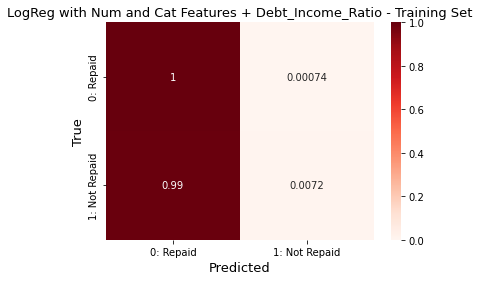

Validation Set with Selected 22 Input Features + Added Debt-Income-Ratio Feature:
	Prediction Time: 0.264s
	Accuracy Score:  0.9164450905752052
	F1 Score:  0.016216216216216217
	AUROC Score:  0.7379045498456364
	Confusion Matrix:


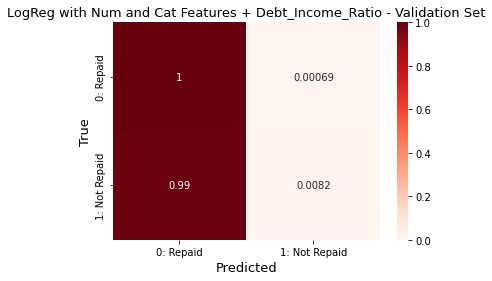

Test Set with Selected 22 Input Features + Added Debt-Income-Ratio Feature:
	Prediction Time: 0.245s
	Accuracy Score:  0.9190712597827736
	F1 Score:  0.011649457241196717
	AUROC Score:  0.7373532848716589
	Confusion Matrix:


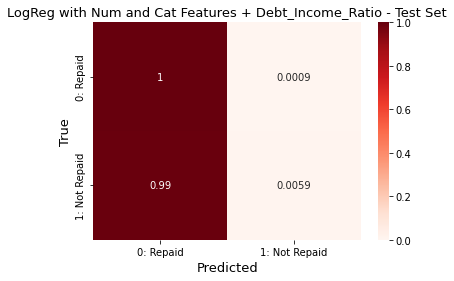

In [48]:
# Training Set
print(f"Training Set with Selected 22 Input Features + Added Debt-Income-Ratio Feature:")
cm_train, y_pred_train, pred_time_train, train_acc, train_f1, train_auroc = predict_and_score(X_train, y_train, model, exp_name+' - Training Set')

# Validation Set
print(f"Validation Set with Selected 22 Input Features + Added Debt-Income-Ratio Feature:")
cm_valid, y_pred_valid, pred_time_valid, valid_acc, valid_f1, valid_auroc = predict_and_score(X_valid, y_valid, model, exp_name+' - Validation Set')

# Test Set
print(f"Test Set with Selected 22 Input Features + Added Debt-Income-Ratio Feature:")
cm_test, y_pred_test, pred_time_test, test_acc, test_f1, test_auroc = predict_and_score(X_test, y_test, model, exp_name+' - Test Set')

In [49]:
expLog.loc[len(expLog)] = [exp_count, 
                           exp_name, 
                           total_inputs,
                           len(all_num_features),
                           len(all_cat_features),
                           round(train_acc, 3), 
                           round(valid_acc, 3),
                           round(test_acc, 3),
                           round(train_f1, 3), 
                           round(valid_f1, 3),
                           round(test_f1, 3),
                           round(train_auroc, 3),                          
                           round(valid_auroc, 3),                                                     
                           round(test_auroc,3),                           
                           train_time, 
                           pred_time_train,
                           pred_time_valid,
                           pred_time_test, 
                           "N/A",
                           "N/A",
                           "N/A",
                           description]

display(expLog)

exp_count += 1

,Experiment Number,Model,# Transformed Input Features,# Original Numerical Features,# Original Categorical Features,Train Acc,Valid Acc,Test Acc,Train F1,Valid F1,...,Valid AUROC,Test AUROC,Training Time,Training Prediction Time,Validation Prediction Time,Test Prediction Time,Hyperparameters,Best Parameter,Best Hypertuning Score,Description
0,1,"Baseline 1, LogReg with Original 17 Selected F...",49,10,7,0.92,0.916,0.919,0.014,0.015,...,0.738,0.737,6.4365,1.037167,0.265764,0.259094,N/A,N/A,N/A,Baseline 1 LogReg Model with Preselected Num a...
1,2,"Baseline 2, LogReg with original 120 Features",250,104,16,0.92,0.916,0.919,0.021,0.019,...,0.747,0.743,12.8944,2.181616,0.495916,0.493019,N/A,N/A,N/A,Baseline 2 LogReg Model with Num and Cat Featu...
2,3,LogReg - L1 Penalty with Selected 17 Features,49,10,7,0.92,0.916,0.919,0.014,0.016,...,0.738,0.737,24.9009,0.581788,0.235044,0.237610,N/A,N/A,N/A,LogReg Model-L1 Penalty with Selected 17 Cat +...
3,4,LogReg - L1 Penalty with 120 Features,250,104,16,0.92,0.916,0.919,0.017,0.014,...,0.745,0.743,82.9160,1.767803,0.484229,0.471008,N/A,N/A,N/A,LogReg Model-L1 Penalty with 104 Num + 16 Cat ...
4,5,"Baseline 3, LogReg with Num and Cat Features +...",251,104,16,0.92,0.916,0.919,0.021,0.018,...,0.746,0.743,11.6482,1.703953,0.512874,0.471745,N/A,N/A,N/A,Logistic Regression Model with Original 120 N...
5,6,LogReg with Num and Cat Features + Debt_Income...,50,104,16,0.92,0.916,0.919,0.014,0.016,...,0.738,0.737,5.3168,0.610801,0.263978,0.245423,N/A,N/A,N/A,Logistic Regression Model with Original 17 Nu...


# Other Experiments Using 17 Selected Input Features: 

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


-----------------------------------------------------
RANDOM FOREST
-----------------------------------------------------
X train           shape: (209107, 17)
X validation      shape: (52277, 17)
X test            shape: (46127, 17)

PERFORMING TRAINING: {exp_name}
	Pipeline: ['preparation', 'clf']
	# Total Features:  17

Numerical Features:
['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'DAYS_BIRTH', 'REGION_RATING_CLIENT_W_CITY', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'REG_CITY_NOT_WORK_CITY', 'AMT_INCOME_TOTAL', 'AMT_CREDIT']
	# Numerical Features:  10

Categorical Features:
['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'OCCUPATION_TYPE']
	# Categorical Features:  7

training in progress...

Baseline Experiment with Original 17 Input Variables - Training Time: 15.829s
Baseline Experiment with 17 Variables - Training Set:
	Prediction Time: 1.950s
	Accuracy Score:  0.9999426131119474
	F1 Score:  0.9996413

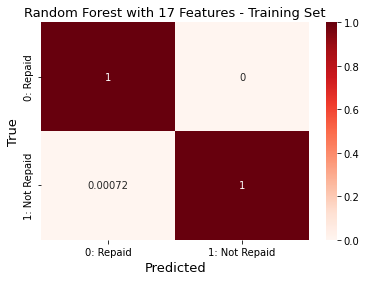

Baseline Experiment with 17 Variables - Validation Set:
	Prediction Time: 0.686s
	Accuracy Score:  0.9163494462191786
	F1 Score:  0.0036454773296878563
	AUROC Score:  0.7191185828405305
	Confusion Matrix:


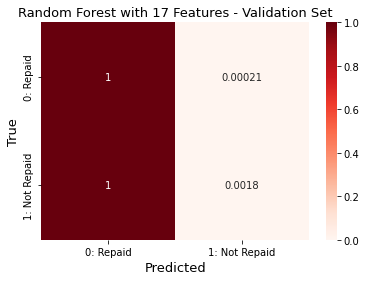

Baseline Experiment with 17 Variables - Test Set:
	Prediction Time: 0.593s
	Accuracy Score:  0.9196349209790361
	F1 Score:  0.008027829810008026
	AUROC Score:  0.721345450591631
	Confusion Matrix:


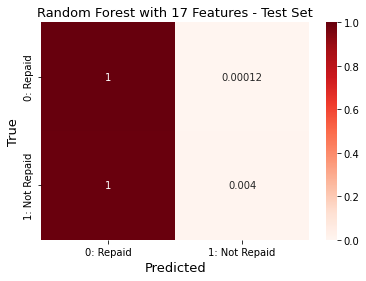

In [51]:
clf_names = ["Random Forest",
#              "SVC"
]

clfs = [RandomForestClassifier(n_jobs=-1, class_weight='balanced'),
#       SVC()
]

for clf_name, clf in zip(clf_names, clfs): 
    
    print("-----------------------------------------------------")
    print(f"{clf_name.upper()}")
    print("-----------------------------------------------------")
    pipe = Pipeline([
        ("preparation", data_pipeline_17),
        ("clf", clf),
    ])
    
    # Name of Experiment
    exp_name = clf_name +" with 17 Features"
    
    # Description of Experiment
    description = f'{clf_name} Model with 10 Num + 7 Cat Features.'
    
    features, X_train, X_valid, X_test, y_train, y_valid, y_test, model, train_time= train_model(train, exp_name, selected_num_features, selected_cat_features, pipe)
    
    
    # Training Set
    print("Baseline Experiment with 17 Variables - Training Set:")
    cm_train, y_pred_train, pred_time_train, train_acc, train_f1, train_auroc = predict_and_score(X_train, y_train, model, exp_name+' - Training Set')

    # Validation Set
    print("Baseline Experiment with 17 Variables - Validation Set:")
    cm_valid, y_pred_valid, pred_time_valid, valid_acc, valid_f1, valid_auroc = predict_and_score(X_valid, y_valid, model, exp_name+' - Validation Set')

    # Test Set
    print("Baseline Experiment with 17 Variables - Test Set:")
    cm_test, y_pred_test, pred_time_test, test_acc, test_f1, test_auroc = predict_and_score(X_test, y_test, model, exp_name+' - Test Set')
    
    expLog.loc[len(expLog)] = [exp_count, 
                           exp_name, 
                           total_inputs_17,
                           len(selected_num_features),
                           len(selected_cat_features),
                           round(train_acc, 3), 
                           round(valid_acc, 3),
                           round(test_acc,3),
                           round(train_f1, 3), 
                           round(valid_f1, 3),
                           round(test_f1,3),
                           round(train_auroc, 3), 
                           round(valid_auroc, 3),                                                      
                           round(test_auroc,3),                               
                           train_time, 
                           pred_time_train,
                           pred_time_valid,
                           pred_time_test, 
                           "N/A",
                           "N/A",
                           "N/A",
                           description]
    exp_count += 1
    


In [52]:
display(expLog)

,Experiment Number,Model,# Transformed Input Features,# Original Numerical Features,# Original Categorical Features,Train Acc,Valid Acc,Test Acc,Train F1,Valid F1,...,Valid AUROC,Test AUROC,Training Time,Training Prediction Time,Validation Prediction Time,Test Prediction Time,Hyperparameters,Best Parameter,Best Hypertuning Score,Description
0,1,"Baseline 1, LogReg with Original 17 Selected F...",49,10,7,0.92,0.916,0.919,0.014,0.015,...,0.738,0.737,6.4365,1.037167,0.265764,0.259094,N/A,N/A,N/A,Baseline 1 LogReg Model with Preselected Num a...
1,2,"Baseline 2, LogReg with original 120 Features",250,104,16,0.92,0.916,0.919,0.021,0.019,...,0.747,0.743,12.8944,2.181616,0.495916,0.493019,N/A,N/A,N/A,Baseline 2 LogReg Model with Num and Cat Featu...
2,3,LogReg - L1 Penalty with Selected 17 Features,49,10,7,0.92,0.916,0.919,0.014,0.016,...,0.738,0.737,24.9009,0.581788,0.235044,0.237610,N/A,N/A,N/A,LogReg Model-L1 Penalty with Selected 17 Cat +...
3,4,LogReg - L1 Penalty with 120 Features,250,104,16,0.92,0.916,0.919,0.017,0.014,...,0.745,0.743,82.9160,1.767803,0.484229,0.471008,N/A,N/A,N/A,LogReg Model-L1 Penalty with 104 Num + 16 Cat ...
4,5,"Baseline 3, LogReg with Num and Cat Features +...",251,104,16,0.92,0.916,0.919,0.021,0.018,...,0.746,0.743,11.6482,1.703953,0.512874,0.471745,N/A,N/A,N/A,Logistic Regression Model with Original 120 N...
5,6,LogReg with Num and Cat Features + Debt_Income...,50,104,16,0.92,0.916,0.919,0.014,0.016,...,0.738,0.737,5.3168,0.610801,0.263978,0.245423,N/A,N/A,N/A,Logistic Regression Model with Original 17 Nu...
6,7,Random Forest with 17 Features,49,10,7,1.00,0.916,0.920,1.000,0.004,...,0.719,0.721,15.8291,1.949938,0.685888,0.592699,N/A,N/A,N/A,Random Forest Model with 10 Num + 7 Cat Features.


In [53]:
# Function Build Barcharts of scores for all models
acc_df = expLog[['Model', 'Train Acc', 'Valid Acc', 'Test Acc']].copy()
F1_df = expLog[['Model','Train F1', 'Valid F1', 'Test F1']].copy()
AUROC_df = expLog[['Model','Train AUROC', 'Valid AUROC', 'Test AUROC']].copy()

def score_barchart(df, title):
    # Plot the bar chart
    df.set_index('Model', inplace=True)
    ax = df.plot(kind='bar', figsize=(10, 6))
    plt.title(f'{title} Score Comparison')
    plt.ylabel(title)
    plt.xticks(rotation=45)
    plt.show()

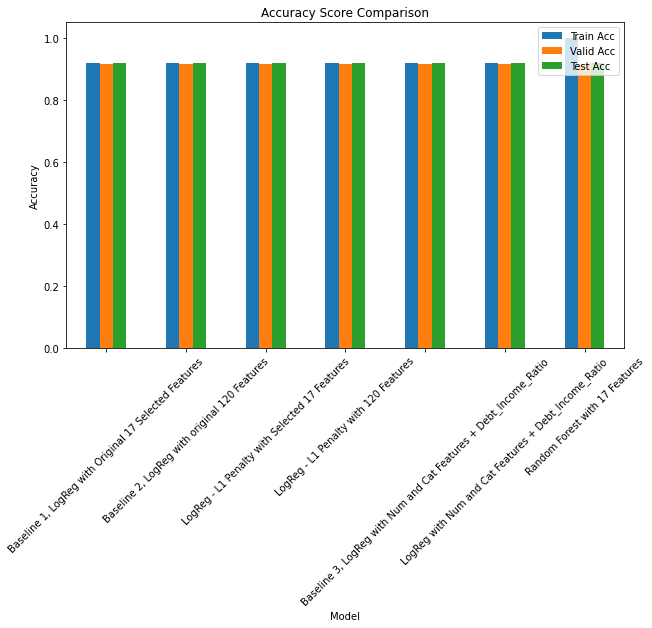

In [54]:
score_barchart(acc_df, 'Accuracy')

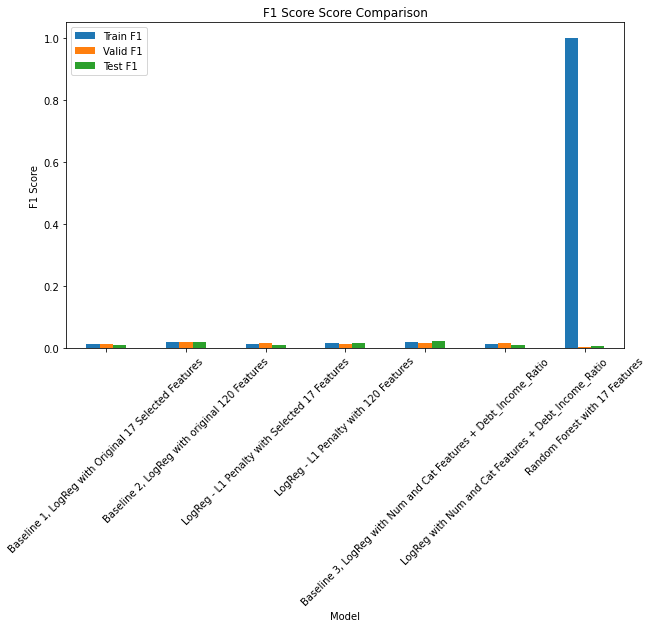

In [55]:
score_barchart(F1_df, 'F1 Score')

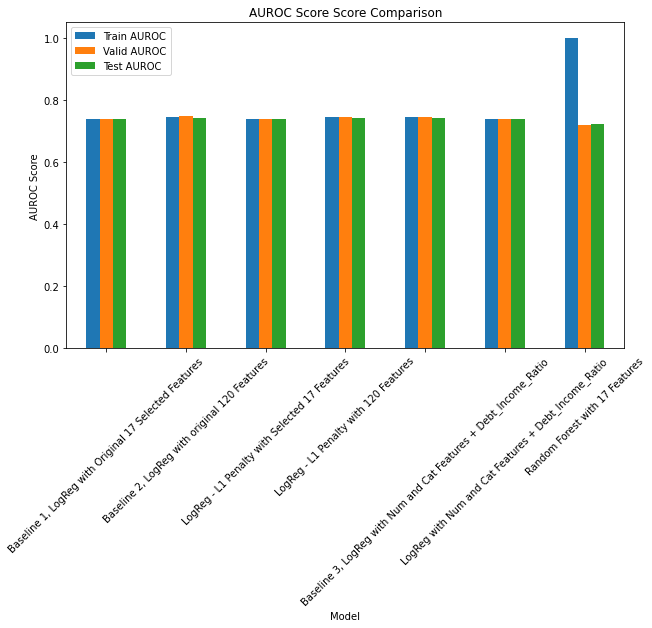

In [56]:
score_barchart(AUROC_df, 'AUROC Score')

# Hyperparameter Tuning

In [57]:
clf_best_parameters = {}

# Function to run GridSearchCV and log experiments
def gs_classifier(in_features, clf_name, clf, parameters, expCount):
    y = train['TARGET']
    X = train[in_features]
    total_selected_inputs = len(in_features)
    
    numerical_features = X.describe().columns.to_list()
    total_num_inputs = len(numerical_features)
    
    categorical_features = set(X.columns.to_list()) - set(numerical_features)
    categorical_features = list(categorical_features)
    total_cat_inputs = len(categorical_features)
    
       
    description = f'{clf_name} with {total_selected_inputs}'
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    
    print(f"X train           shape: {X_train.shape}")
    print(f"X validation      shape: {X_valid.shape}")
    print(f"X test            shape: {X_test.shape}")
    
    
    data_pipeline = ColumnTransformer(transformers=[
            ("num_pipeline", num_pipeline, numerical_features),
            ("cat_pipeline", cat_pipeline, categorical_features)],
            remainder='drop',
            n_jobs=-1
        )
    
    clf_pipeline = Pipeline([
            ("preparation", data_pipeline),# combination of numerical, categorical subpipelines
            ("clf", clf)  # classifier estimator you are using
        ])

    gs = GridSearchCV(clf_pipeline,
                      parameters,
                      scoring=['f1','roc_auc'],
                      cv=3,
                      refit='roc_auc',
                      n_jobs=-1,
                      verbose=1)

    print("\nPERFORMING GRID SEARCH FOR {}...".format(clf_name.upper()))
    print("\tpipeline:",[name for name, _ in clf_pipeline.steps])
    print("\tparameters:", parameters)
    print()

    start = time()
    gs.fit(X_train, y_train)

    train_time = time() - start
    print("\tTraining Time: %0.3fs" % (time() - start))
    print()
    
    # Training Set
    print(f"{clf_name} Training Set with {total_selected_inputs} Input Features:")
    cm_train, y_pred_train, pred_time_train, train_acc, train_f1, train_auroc = predict_and_score(X_train, y_train, model, exp_name+' - Training Set')

    # Validation Set
    print(f"{clf_name} Validation Set with {total_selected_inputs} Input Features:")
    cm_valid, y_pred_valid, pred_time_valid, valid_acc, valid_f1, valid_auroc = predict_and_score(X_valid, y_valid, model, exp_name+' - Validation Set')

    # Test Set
    print(f"{clf_name} Experiment Test Set with {total_selected_inputs} Input Features:")
    cm_test, y_pred_test, pred_time_test, test_acc, test_f1, test_auroc = predict_and_score(X_test, y_test, model, exp_name+' - Test Set')


    print("\n\tBest score: %0.3f" % gs.best_score_)
    print("\tBest parameters set:")
    best_parameters = gs.best_estimator_.get_params()

    best_parameters_dict = {}
    for param_name in sorted(parameters.keys()):
        print("\t\t%s: %r" % (param_name, best_parameters[param_name]))
        best_parameters_dict[param_name] = best_parameters[param_name]
        clf_best_parameters[clf_name] = best_parameters_dict    
    print()
    print()

    expLog.loc[len(expLog)] = [exp_count, 
                           clf_name, 
                           total_selected_inputs,
                           total_num_inputs,
                           total_cat_inputs,
                           round(train_acc, 3), 
                           round(valid_acc, 3),
                           round(test_acc, 3),
                           round(train_f1, 3), 
                           round(valid_f1, 3),
                           round(test_f1, 3),
                           round(train_auroc, 3),                          
                           round(valid_auroc, 3),                                                     
                           round(test_auroc,3), 
                           train_time, 
                           pred_time_train,
                           pred_time_valid,
                           pred_time_test, 
                           parameters,
                           best_parameters_dict,
                           round(gs.best_score_,3),
                           description]
    
    exp_count += 1

In [ ]:
# Grid Search over Preparation Pipeline and Classifiers

clf_names = ["Random Forest",
#              "Logistic Regression", 
#              "SVC",
]

estimators = [RandomForestClassifier(),
#               LogisticRegression(solver='saga'),
#              SVC(),
]

param_grids = [{'clf__n_estimators':[100,200,400,800,1000],
                'clf__max_features':['sqrt','log2',None]},
                'clf__max_depth':[5,10,20,50,100,None], #Try to limit overfitting based on prev exp.
                'clf__max_leaf_nodes':[3,6,9]
                       
#                 'clf__C': [1.0, 10.0, 100.0, 1000.0, 10000.0],
#                 'clf__penalty':[None, 'l1','l2']},
#               {'clf__C': [0.001, 0.01, 0.1, 1.], 
#                'clf__kernel': ["linear", "poly", "rbf", "sigmoid"],
#                'clf__gamma':["scale", "auto"]}
]


selected_features = selected_num_features + selected_cat_features
for clf_name, clf, parameters in zip(clf_names, estimators, param_grids): 
    gs_classifier(selected_features, clf_name, clf, parameters)

X train           shape: (209107, 17)
X validation      shape: (52277, 17)
X test            shape: (46127, 17)

PERFORMING GRID SEARCH FOR LOGISTIC REGRESSION...
	pipeline: ['preparation', 'clf']
	parameters: {'clf__C': [1.0, 10.0, 100.0, 1000.0, 10000.0], 'clf__penalty': [None, 'l1', 'l2']}

Fitting 3 folds for each of 15 candidates, totalling 45 fits


In [ ]:
display(expLog)

In [ ]:
# Function Build Barcharts of scores for all models
acc_df = expLog[['Model', 'Train Acc', 'Valid Acc', 'Test Acc']].copy()
F1_df = expLog[['Model','Train F1', 'Valid F1', 'Test F1']].copy()
AUROC_df = expLog[['Model','Train AUROC', 'Valid AUROC', 'Test AUROC']].copy()

# Write-up 
## ML Pipelines 
The pipelines used in this project were used to increase the efficiency and ease of understanding of our code. Our most basic pipelines (Level 3 Pipelines) were used to prepare our selected input feature data. The numerical features and categorical features were each handled in their own pipelines. Numerical data was standardized while categorical data was one-hot-encoded. In both sets, the pipelines handled imputing missing values. The Level 2 Pipeline, was a column transformer used to streamline the preparation of data before it is applied to our classifier, combining both numerical and categorical pipelines. Lasty, the Level 1 Pipeline was used to combine the Level 2 data preparation pipeline to the classifer model. 

Our baseline pipelines: 
- Logistic Regression model with 22 selected input features from application_train. 
- Logistic Regression model with all 120 input features from application train (does not include SK_ID_CURR). 
- Logistic Regression model with both sets of input features using L1 penalty term. 

We also ran experiments using Logisitic regression  with a newly feature engineered, Debt to Income Ratio, using application_train features: 'AMT_CREDIT' and 'AMT_INCOME TOTAL'. Debt to Income Ratio is a good measure of ability to pay back loans, showing how much of a person's income will go out to pay debt. According to Wells Fargo.com (https://www.wellsfargo.com/goals-credit/smarter-credit/credit-101/debt-to-income-ratio/understanding-dti/#:~:text=35%25%20or%20less%3A%20Looking%20Good,a%20lower%20DTI%20as%20favorable.), A Debt-to-Income Ratio of 35% of less is considered good, 36-49% shows room for improvement, and over 50% show a need to take action.

Lastly, we ran an experiment using a Random Forest model. 



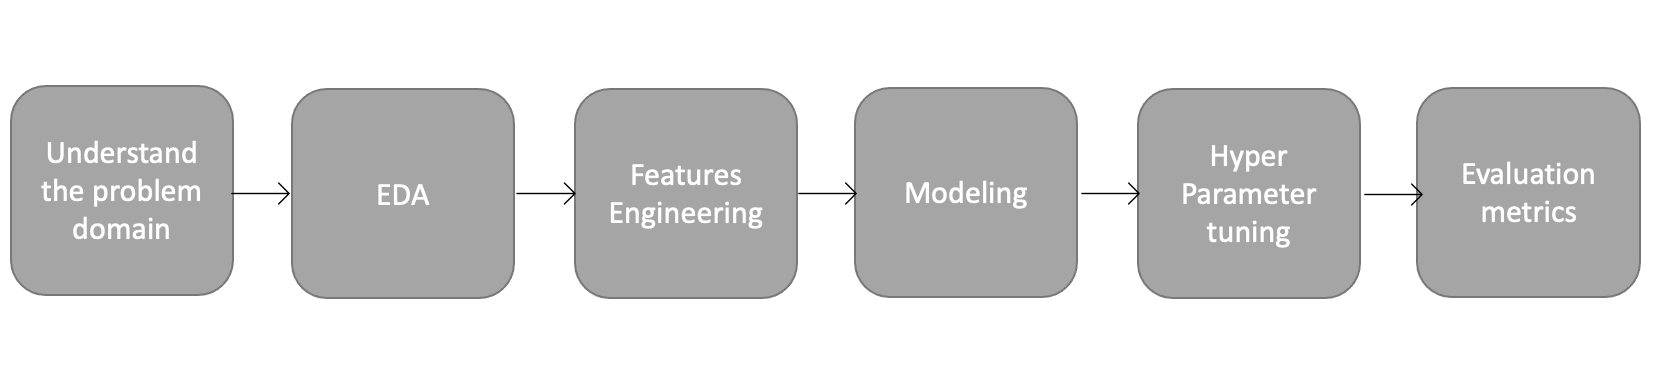

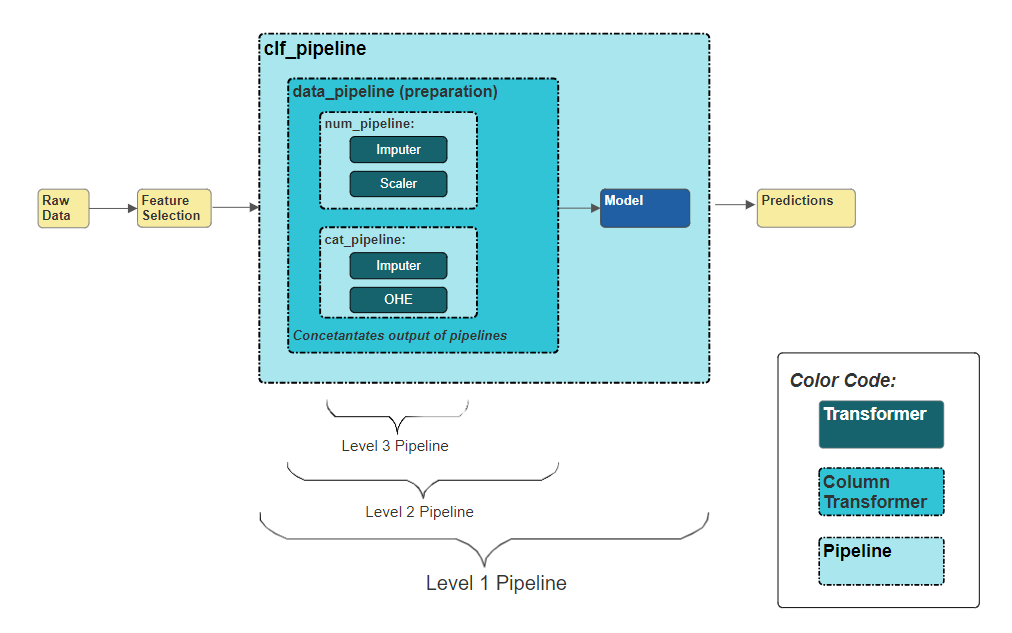

### Experiment Log

In [ ]:
expLog.set_index('Experiment Number', inplace=True)
display(expLog)

## Loss Functions

**Logistic function**

$$ \sigma(t) = \dfrac{1}{1 + \exp(-t)} $$ 


**Logistic Regression model prediction**

$$
\hat{y} =
\begin{cases}
  0 & \text{if } \hat{p} < 0.5, \\
  1 & \text{if } \hat{p} \geq 0.5.
\end{cases}
$$


**Cost function of a single training instanc**

$$
c(\boldsymbol{\theta}) =
\begin{cases}
  -\log(\hat{p}) & \text{if } y = 1, \\
  -\log(1 - \hat{p}) & \text{if } y = 0.
\end{cases}
$$


**Binary Cross-Entropy Loss (CXE)**

Binary Cross Entropy loss, aka log loss, is a special case of negative log likelihood. It measures a classifier's performance, increases as the predicted probability moves farther from the true label. The goal in logistic regression is to minimize the CXE. 
 $$
J(\boldsymbol{\theta}) = -\dfrac{1}{m} \sum\limits_{i=1}^{m}{\left[ y^{(i)} log\left(\hat{p}^{(i)}\right) + (1 - y^{(i)}) log\left(1 - \hat{p}^{(i)}\right)\right]}
$$


**LASSO Binary Cross Entropy (LBXE)** 
$$
J(\boldsymbol{\theta}) = -\dfrac{1}{m} \sum\limits_{i=1}^{m}{\left[ y^{(i)} log\left(\hat{p}^{(i)}\right) + (1 - y^{(i)}) log\left(1 - \hat{p}^{(i)}\right)\right]}  + \lambda \sum_{j=1}^{n}|w_j|
$$


**Ridge Binary Cross Entropy (RBXE)** 
$$
J(\boldsymbol{\theta}) = -\dfrac{1}{m} \sum\limits_{i=1}^{m}{\left[ y^{(i)} log\left(\hat{p}^{(i)}\right) + (1 - y^{(i)}) log\left(1 - \hat{p}^{(i)}\right)\right]} + \lambda \sum_{j=1}^{n}w_j^2
$$


**Primal Soft Margin SVM Classifier**
$$ {\displaystyle \underset{W,b, \zeta}{\text{argmin }}{\overbrace{\dfrac{1}{2}}^A \underbrace{\mathbf{w}^T \cdot \mathbf{w}}_B \quad + }C\sum _{i=1}^{m}\zeta _{i}} $$


## Evaluation Metrics

###  Accuracy Score 
$$ \text{Accuracy} = \cfrac{TP + TN}{TP + TN + FP + FN} $$


In [ ]:
score_barchart(acc_df, "Accuracy")

### F1 Score

$$ \text{precision} = \cfrac{TP}{TP + FP} $$


$$\text{recall} = \cfrac{TP}{TP + FN}$$

<br>
$$
F_1 = \cfrac{2}{\cfrac{1}{\text{precision}} + \cfrac{1}{\text{recall}}} = 2 \times \cfrac{\text{precision}\, \times \, \text{recall}}{\text{precision}\, + \, \text{recall}} = \cfrac{TP}{TP + \cfrac{FN + FP}{2}}
$$



In [ ]:
score_barchart(F1_df, "F1")

### Area Under the Receiver Operating Characteristics (AUROC)

$$\text{TPR (aka recall or specificity)} = \cfrac{TP}{TP + FN}$$


<br>
$$ \text{Specificity} = \cfrac{TN}{TN + FP} $$


<br>
$$ \text{FPR = 1 - Specificity}  = \cfrac{FP}{TN + FP} $$

In [ ]:
score_barchart(AUROC_df, "AUROC")

**References:** 
- "List Highest Correlation Pairs from a Large Correlation Matrix in Pandas?". Asked July 22, 2013 by Kyle Brandt. 
    Stack Overflow, "https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas".  <br>
    Answered January 3, 2017 by Arun. Licensed under Creative Commons. <br>
    
    
- "Sort Correlation Matrix in Python. Accessed 11/23/23.
    geeksforgeeks.com, ("https://www.geeksforgeeks.org/sort-correlation-matrix-in-python/)<br>
    
    
- " What is a Good Debt-to-Income Ratio?". Accessed 11/20/2023. 
    Wellsfargo.com, (https://www.wellsfargo.com/goals-credit/smarter-credit/credit-101/debt-to-income-ratio/understanding-dti/#:~:text=35%25%20or%20less%3A%20Looking%20Good,a%20lower%20DTI%20as%20favorable.)<br>
    

In [3]:
docker stats

SyntaxError: invalid syntax (<ipython-input-3-2d47f314ec3d>, line 1)